# Forecast the CocaCola prices
# Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

In [426]:
# Import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import datetime
from scipy.stats import boxcox
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

In [427]:
# Load the dataset ' CocaCola_Sales_Rawdata.xlsx '
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [428]:
df.head()

Quarter        Sales
0   Q1_86  1734.827000
1   Q2_86  2244.960999
2   Q3_86  2533.804993
3   Q4_86  2154.962997
4   Q1_87  1547.818996

In [429]:
df.shape

(42, 2)

In [430]:
len(df)

42

In [431]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


# The data set has been loaded properly and there are no null values in the data set.But the data date stamp is not in a corect format , we wil convert it to standard format

In [432]:
df.head()

Quarter        Sales
0   Q1_86  1734.827000
1   Q2_86  2244.960999
2   Q3_86  2533.804993
3   Q4_86  2154.962997
4   Q1_87  1547.818996

# Feature Engineering

In [433]:
# Convert the quarter into year and quarter
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))

In [434]:
df.head()

Quarter        Sales Quarter_Year
0   Q1_86  1734.827000      Q1 1986
1   Q2_86  2244.960999      Q2 1986
2   Q3_86  2533.804993      Q3 1986
3   Q4_86  2154.962997      Q4 1986
4   Q1_87  1547.818996      Q1 1987

In [435]:
# We will convert quarter_year to standard date time format
df['Date'] = (pd.to_datetime(df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))

In [436]:
df.head()

Quarter        Sales Quarter_Year       Date
0   Q1_86  1734.827000      Q1 1986 1986-01-01
1   Q2_86  2244.960999      Q2 1986 1986-04-01
2   Q3_86  2533.804993      Q3 1986 1986-07-01
3   Q4_86  2154.962997      Q4 1986 1986-10-01
4   Q1_87  1547.818996      Q1 1987 1987-01-01

In [437]:
len(df)

42

In [438]:
# We will assign the quarters of the each year to the data frame
df['Quarters'] = 0

for q in range(42):
    n = df['Quarter'][q]
    df['Quarters'][q] = n[0:2]

In [439]:
df.head()

Quarter        Sales Quarter_Year       Date Quarters
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1

In [440]:
# Drop the unnecesary columns from the data frame
df.drop(['Quarter','Quarter_Year'],axis = 1, inplace =True)

In [441]:
df.head()

Sales       Date Quarters
0  1734.827000 1986-01-01       Q1
1  2244.960999 1986-04-01       Q2
2  2533.804993 1986-07-01       Q3
3  2154.962997 1986-10-01       Q4
4  1547.818996 1987-01-01       Q1

In [442]:
# Create a dummy variable for quarters
dummy = pd.get_dummies(df['Quarters'])

In [443]:
df = pd.concat((df,dummy),axis = 1)

In [444]:
df.head()

Sales       Date Quarters  Q1  Q2  Q3  Q4
0  1734.827000 1986-01-01       Q1   1   0   0   0
1  2244.960999 1986-04-01       Q2   0   1   0   0
2  2533.804993 1986-07-01       Q3   0   0   1   0
3  2154.962997 1986-10-01       Q4   0   0   0   1
4  1547.818996 1987-01-01       Q1   1   0   0   0

In [445]:
# Converting the Date as a index to the data frame
df.set_index('Date',inplace = True)

In [446]:
df.head()

Sales Quarters  Q1  Q2  Q3  Q4
Date                                            
1986-01-01  1734.827000       Q1   1   0   0   0
1986-04-01  2244.960999       Q2   0   1   0   0
1986-07-01  2533.804993       Q3   0   0   1   0
1986-10-01  2154.962997       Q4   0   0   0   1
1987-01-01  1547.818996       Q1   1   0   0   0

In [447]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42 entries, 1986-01-01 to 1996-04-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sales     42 non-null     float64
 1   Quarters  42 non-null     object 
 2   Q1        42 non-null     uint8  
 3   Q2        42 non-null     uint8  
 4   Q3        42 non-null     uint8  
 5   Q4        42 non-null     uint8  
dtypes: float64(1), object(1), uint8(4)
memory usage: 1.1+ KB


# Now the date has been set as index of the data frame

# Visualization 

In [448]:
plt.rcParams['figure.figsize'] = (10,6)

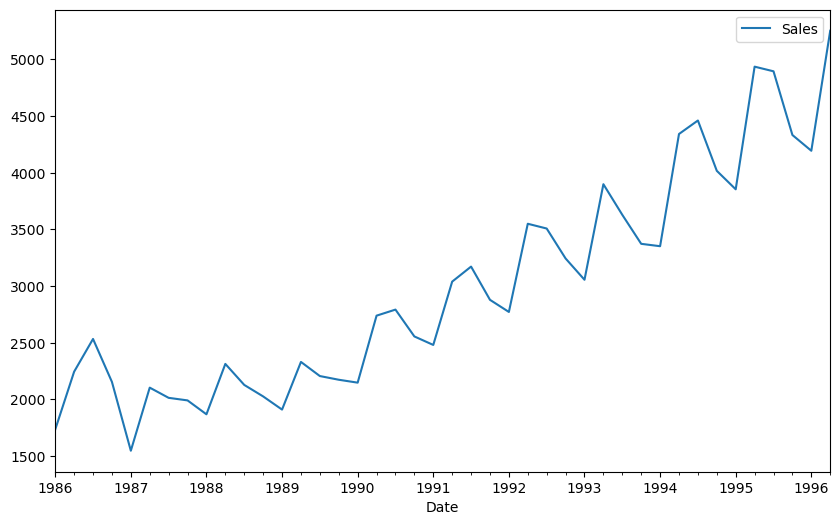

In [449]:
df['Sales'].plot(legend = True,label = 'Sales');

# From the above line plot , There is a increase in trend and we can observe seasonality also in the line plot as the sales are decreasing in the initial months of each year

# Heat map visualisation

In [450]:
df_pivot = df.pivot_table(values = 'Sales',index = df.index.year , columns = df.index.month)
df_pivot

Date           1            4            7            10
Date                                                    
1986  1734.827000  2244.960999  2533.804993  2154.962997
1987  1547.818996  2104.411995  2014.362999  1991.746998
1988  1869.049999  2313.631996  2128.320000  2026.828999
1989  1910.603996  2331.164993  2206.549995  2173.967995
1990  2148.278000  2739.307999  2792.753998  2556.009995
1991  2480.973999  3039.522995  3172.115997  2879.000999
1992  2772.000000  3550.000000  3508.000000  3243.859993
1993  3056.000000  3899.000000  3629.000000  3373.000000
1994  3352.000000  4342.000000  4461.000000  4017.000000
1995  3854.000000  4936.000000  4895.000000  4333.000000
1996  4194.000000  5253.000000          NaN          NaN

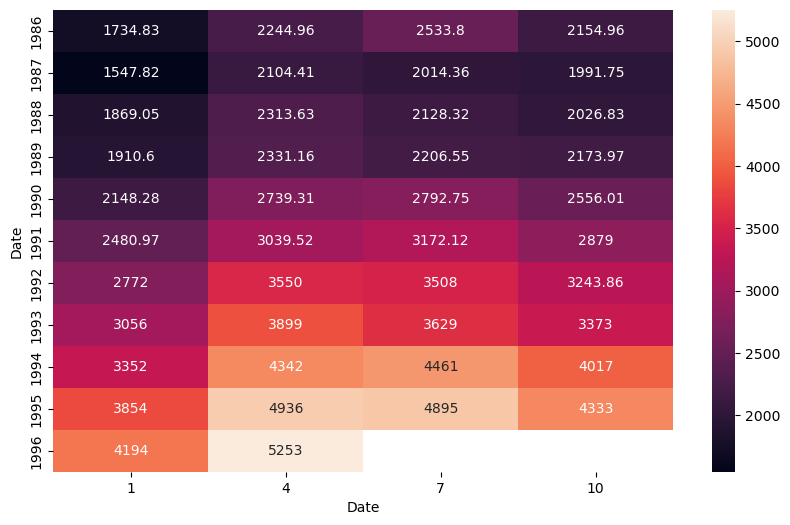

In [451]:
sns.heatmap(df_pivot , annot =True, fmt='g');

# From the heatmap visualization , we can say that there is a increase trend from quarter-1 to quarter-3 and then decreasing trend from quarter-3 to quarter-4 and subsequently from quarter-4 to quarter-1

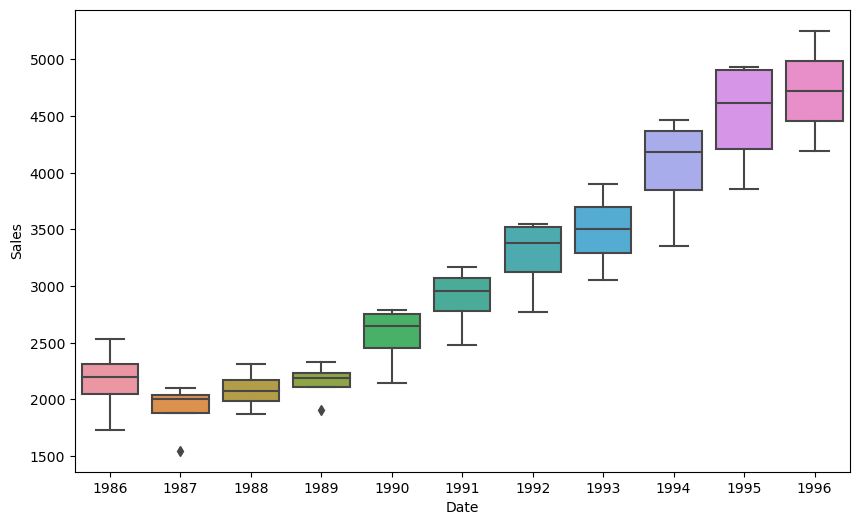

In [452]:
# BOX PLOT VISUALIZATION OF THE DATA
sns.boxplot(data = df , x = df.index.year, y = 'Sales');

# From the above box plot visualization, there is a increse in the trend

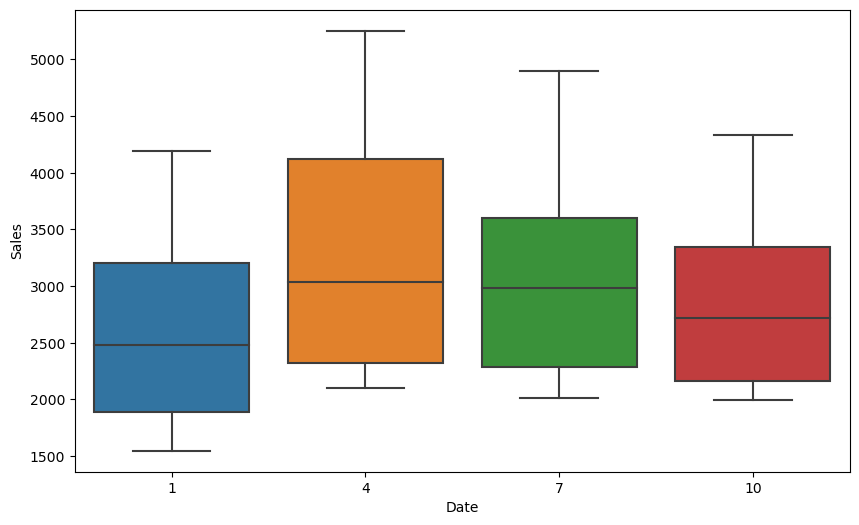

In [453]:
# Box plot visualization for the month 
sns.boxplot(data = df, x = df.index.month, y = 'Sales');

# From the above box plot, we can say that the sales are less in the quarter-1 and increasing in the quarter-2 and decreasing form quarter-2 to 3 and further decreasing to quarter-4

# From the above , we can say that there is a trend ans seasonality is there in the data

# Histogram and density plot

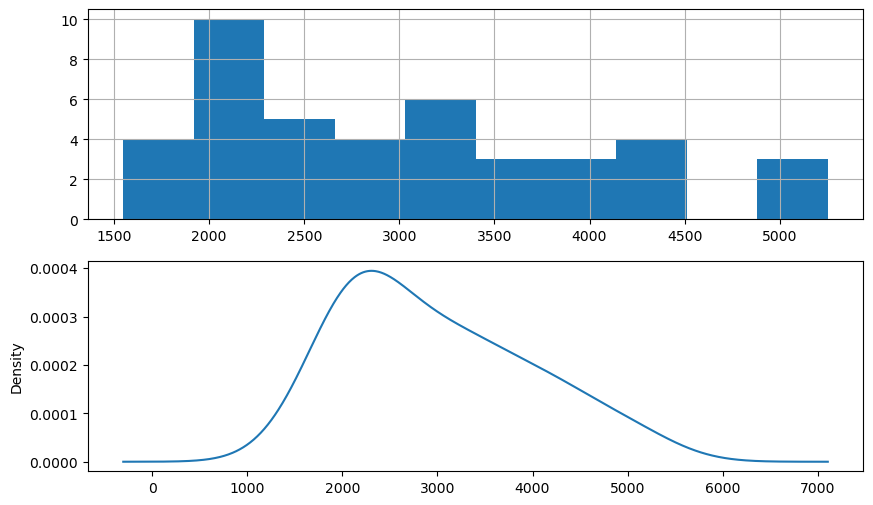

In [454]:
plt.subplot(211)
df.Sales.hist()
plt.subplot(212)
df.Sales.plot(kind='kde')
plt.show()

# Lag plot - Correlation between a time series and a lagged version of itself

In [455]:
# Import lag plot
from pandas.plotting import lag_plot

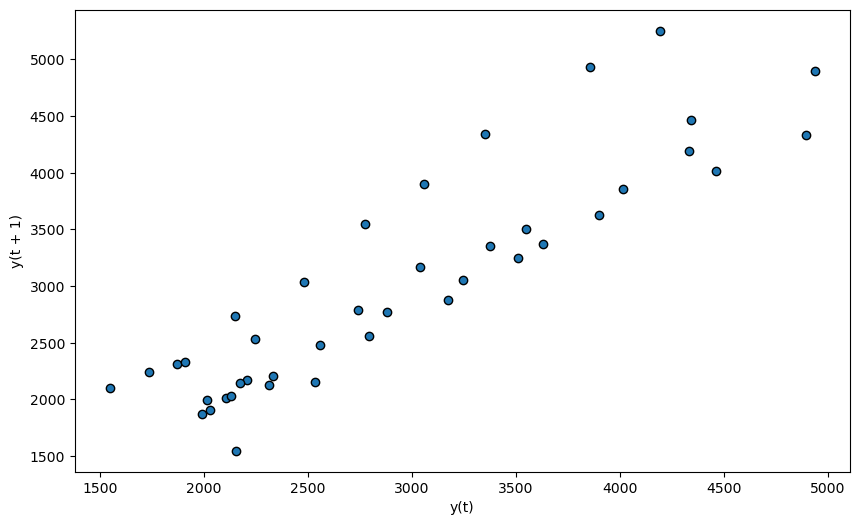

In [456]:
lag_plot(df['Sales'],edgecolor = 'k'); # Default lag = 1

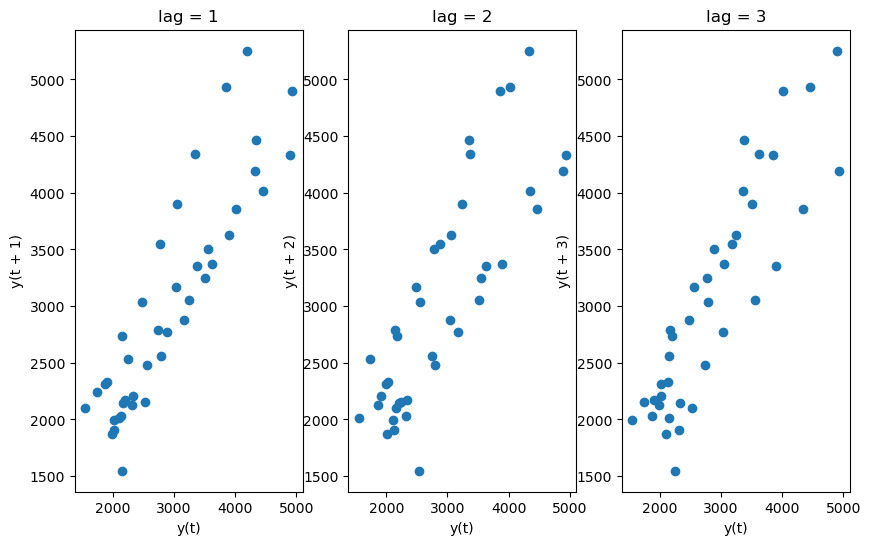

In [457]:
# Lag plot with a lag of 1,2 and 3
fig,ax = plt.subplots(1,3)

for i,lag in enumerate([1,2,3]):
    lag_plot(df['Sales'],lag = lag,ax = ax[i])
    ax[i].set_title(f'lag = {lag}')

# Moving average model

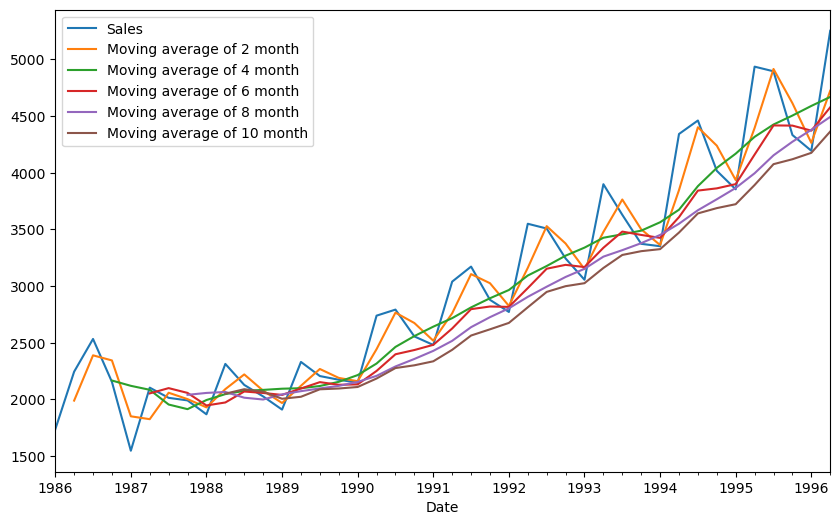

In [458]:
# plot the time series with rolling mean of 2 to 24 with step of 6 months
fig,ax = plt.subplots()
df['Sales'].plot(ax = ax,label = 'Sales')
for i in range(2,12,2):\
    df['Sales'].rolling(i).mean().plot(ax = ax,label = f'Moving average of {i} month')
ax.legend();

# The moving average with 2 is able to capture the trend and seasonality some what but not aligned with the original sales vales as the moving average increased , not able to capture the seasonality

# Decomposition of time series into TREND , SEASONALITY and RESIDUAL

In [459]:
# Decomposition plot
decomposition = seasonal_decompose(df['Sales'],model='additive')

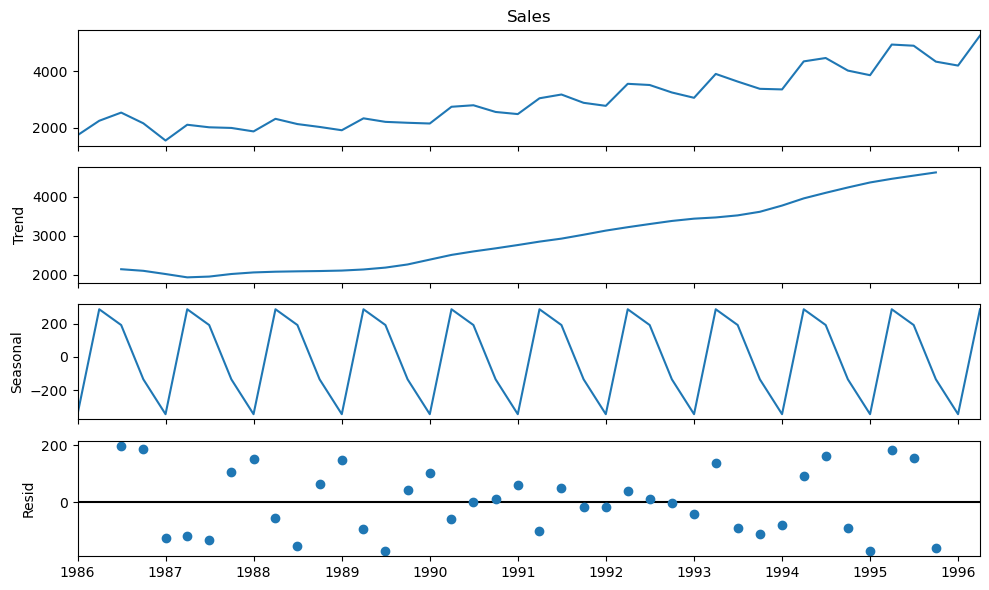

In [460]:
decomposition.plot();

# # The residual values are lie on the both side of the value 0.We can say that there is a additive seasonality in the data

In [461]:
# MULTIPLICATE DECOMPOSITION PLOT
season_multi = seasonal_decompose(df['Sales'],model = 'multiplicative')

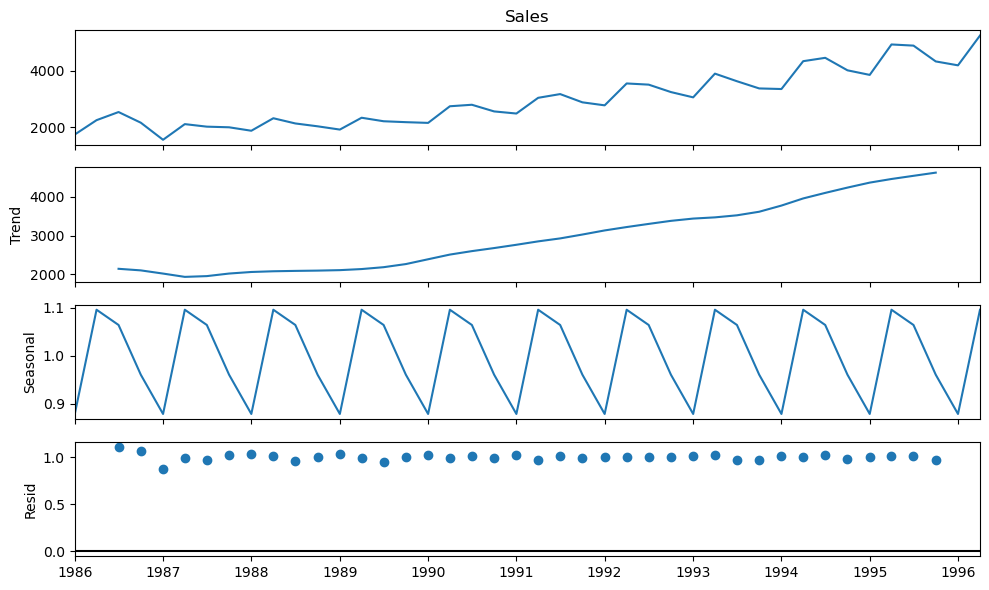

In [462]:
season_multi.plot();

# Auto Correltion plot - ACF and PACF

# The AutoCorrelation Function (ACF) plot is a graphical tool used in time series analysis to visualize the correlation of a series with its own past values at different lags. In other words, it shows how well the present value of a time series is related to its past values.

In [463]:
# Plot ACF using plot_acf
from statsmodels.graphics.tsaplots import plot_acf

In [464]:
df.head()

Sales Quarters  Q1  Q2  Q3  Q4
Date                                            
1986-01-01  1734.827000       Q1   1   0   0   0
1986-04-01  2244.960999       Q2   0   1   0   0
1986-07-01  2533.804993       Q3   0   0   1   0
1986-10-01  2154.962997       Q4   0   0   0   1
1987-01-01  1547.818996       Q1   1   0   0   0

# Drop further unnecessary columns

In [465]:
df.drop(['Quarters','Q1','Q2','Q3','Q4'],axis = 1, inplace = True)

In [466]:
df.head()

Sales
Date                   
1986-01-01  1734.827000
1986-04-01  2244.960999
1986-07-01  2533.804993
1986-10-01  2154.962997
1987-01-01  1547.818996

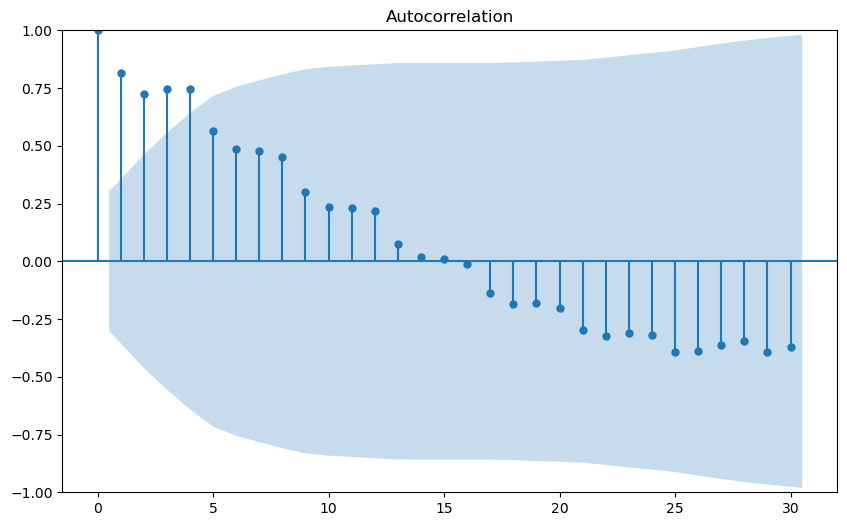

In [467]:
# Plotting the auto correlation plot
plot_acf(df,lags = 30);

# Plotting the PACF plot

In [468]:
# Plot PACF
from statsmodels.graphics.tsaplots import plot_pacf

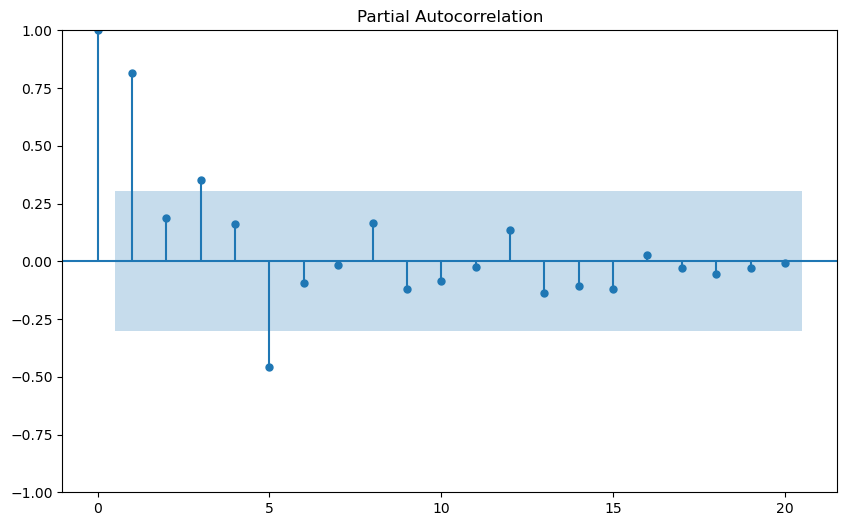

In [469]:
plot_pacf(df,lags = 20);

# The Partial AutoCorrelation Function (PACF) is a statistical method used in time series analysis to analyze the relationship between an observation and its lagged values, while taking into account the effect of the intervening observations. In other words, PACF measures the correlation between a time series and its own lag, controlling for the values of the time series at all shorter lags.

# Split the data into train and test.We are going to forecast the sales for 2 years so we will include 2 years data in the test data

In [470]:
train = df.iloc[:34]

In [471]:
test = df.iloc[34:]

In [472]:
train.shape, test.shape

((34, 1), (8, 1))

In [473]:
train.head()

Sales
Date                   
1986-01-01  1734.827000
1986-04-01  2244.960999
1986-07-01  2533.804993
1986-10-01  2154.962997
1987-01-01  1547.818996

In [474]:
train.tail()

Sales
Date              
1993-04-01  3899.0
1993-07-01  3629.0
1993-10-01  3373.0
1994-01-01  3352.0
1994-04-01  4342.0

In [475]:
test.head()

Sales
Date              
1994-07-01  4461.0
1994-10-01  4017.0
1995-01-01  3854.0
1995-04-01  4936.0
1995-07-01  4895.0

In [476]:
test.tail()

Sales
Date              
1995-04-01  4936.0
1995-07-01  4895.0
1995-10-01  4333.0
1996-01-01  4194.0
1996-04-01  5253.0

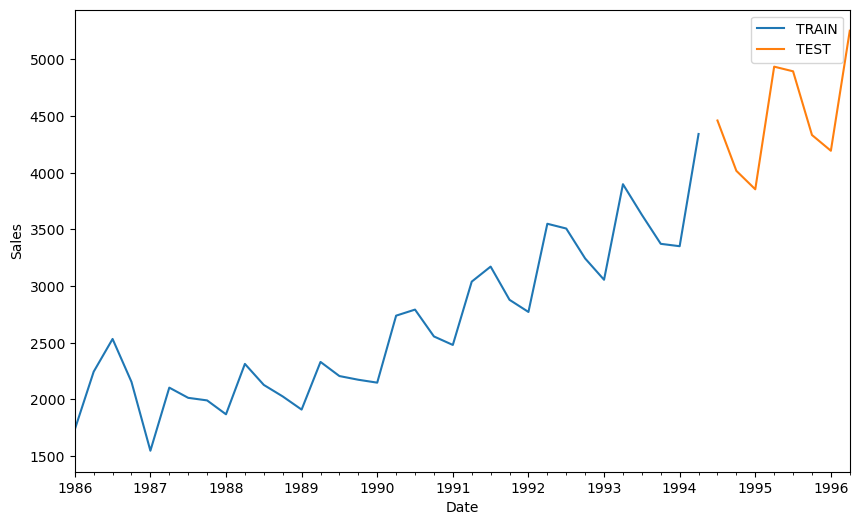

In [477]:
# Plot the train and test data
plt.xlabel('Date')
plt.ylabel('Sales')
train['Sales'].plot(legend = True,label = 'TRAIN')
test['Sales'].plot(legend= True , label ='TEST');

# EXPONENTIAL MODELS

# Simple Exponential smooting model

In [478]:
# train a SES model on the train set and predict the values an the test set and plot train, test and predict values
ses_model = SimpleExpSmoothing(train['Sales']).fit()
ses_predict = ses_model.predict(start = test.index[0],end = test.index[-1])

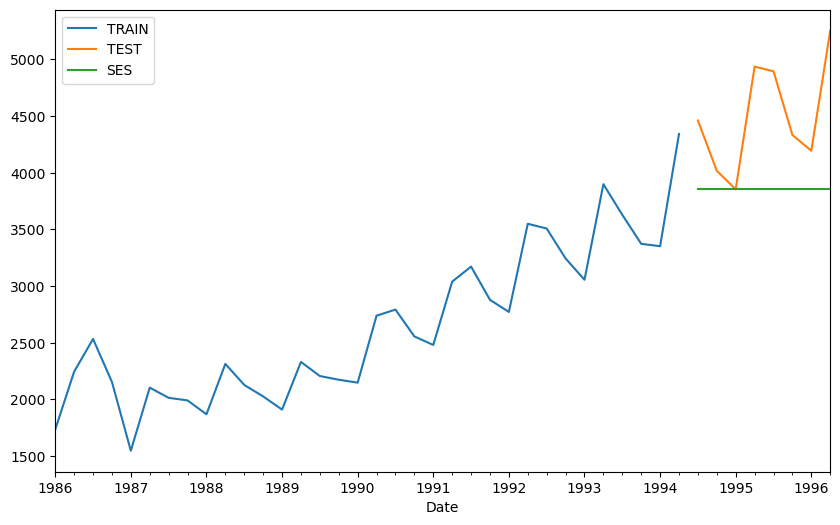

In [479]:
# Plot the values
train['Sales'].plot(legend = True,label ='TRAIN')
test['Sales'].plot(legend = True,label = 'TEST')
ses_predict.plot(legend= True,label = 'SES');

In [480]:
# Calculate rmse
rmse_ses = rmse(test['Sales'],ses_predict)
rmse_ses

786.8359859975462

In [481]:
test['Sales'].mean()

4492.875

In [482]:
787*100/4493

17.516136211885154

# The model performace is not able to capture either trend or seasonality and RMSE of the model is very high and on an average the model is not able to predict the 18% values in the forecast

# HOLT or DOUBLE EXPONENTIAL SMOOTHING MODEL

In [483]:
# import the exponential smmothing model from statsmodels
from statsmodels.tsa.api import Holt,ExponentialSmoothing,SimpleExpSmoothing
model_holt = Holt(train['Sales']).fit()
predict_holt = model_holt.predict(start = test.index[0],end = test.index[-1])

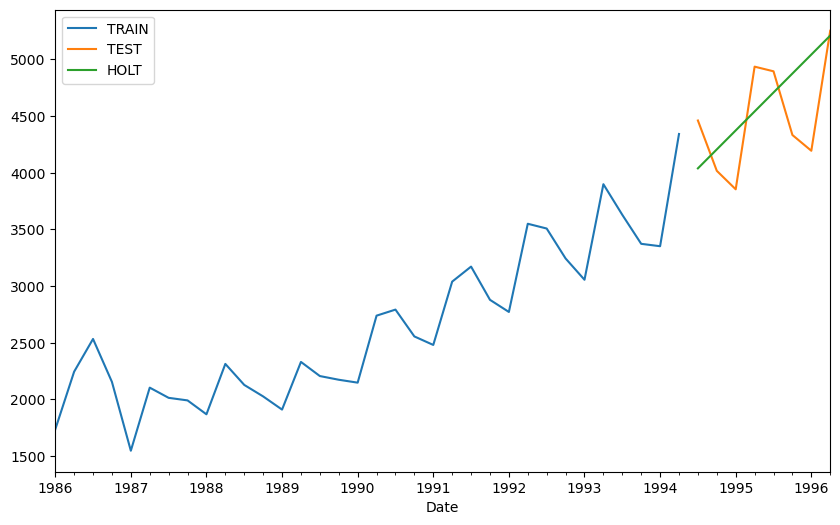

In [484]:
# plot the train,test and predicted values
train['Sales'].plot(legend = True,label ='TRAIN')
test['Sales'].plot(legend = True,label = 'TEST')
predict_holt.plot(legend = True, label = 'HOLT');

In [485]:
# CALCULATE RMSE
rmse_holt = rmse(test['Sales'],predict_holt)
rmse_holt

459.78009660420486

In [486]:
test['Sales'].mean()

4492.875

In [487]:
460*100/4493

10.238148230580904

# From the above , we can say that the model is able to capture the trend but it is not aligned with the test results and RMSE of the model is reduced but not upto the mark

# HOLT winter model (Triple exponential smoothing)

# Holt winter model with additive trend and seasonality

In [488]:
model_hw_add = ExponentialSmoothing(train['Sales'],trend = 'add',seasonal='add',
                                seasonal_periods=12).fit()
predict_hw_add = model_hw_add.predict(test.index[0],test.index[-1])

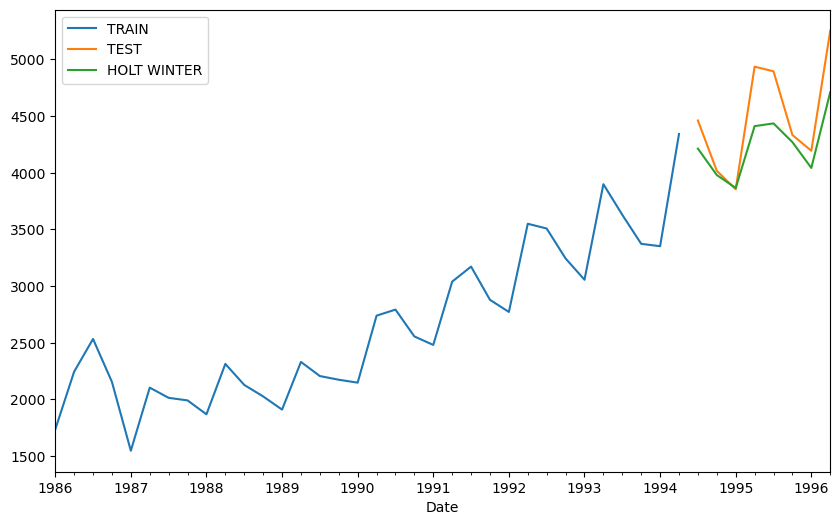

In [489]:
# Plot the train, test and predicted values
train['Sales'].plot(legend = True,label ='TRAIN')
test['Sales'].plot(legend = True,label = 'TEST')
predict_hw_add.plot(legend = True,label = 'HOLT WINTER');

In [490]:
# Calculate RMSE
rmse_hw_add = rmse(test['Sales'],predict_hw_add)
rmse_hw_add

330.0800000287727

In [491]:
test['Sales'].mean()

4492.875

In [492]:
330*100/4493

7.344758513242822

# The Triple exponential model with additive seasonality and trend is able to capture the trend and easonality but not aligned with the test data and model RMSE when compared to Simple exponential smoothing and Holt model is less.We will try other Holt winter models for better performance

# Holt winter model with multiplicative seasonality and additive trend

In [493]:
model_hw_add_mul = ExponentialSmoothing(train['Sales'],trend = 'add',seasonal='mul',
                                seasonal_periods=12).fit()
predict_hw_add_mul = model_hw_add_mul.predict(test.index[0],test.index[-1])

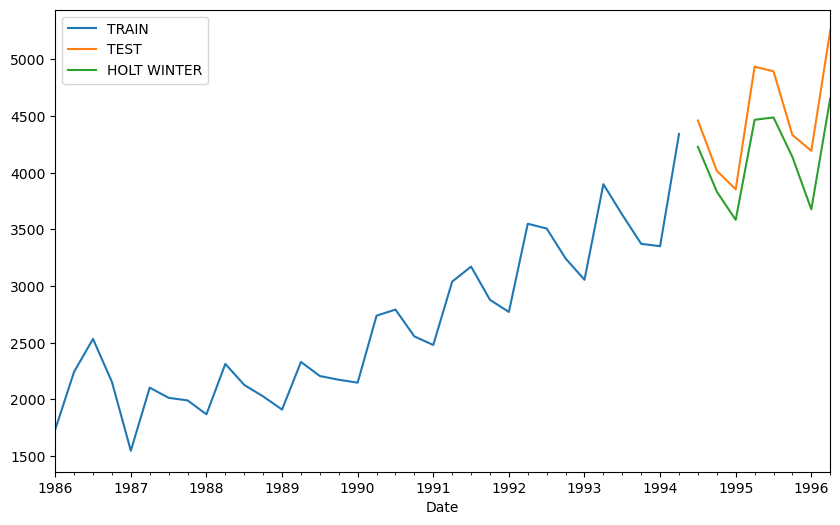

In [494]:
# Plot the train, test and predicted values
train['Sales'].plot(legend = True,label ='TRAIN')
test['Sales'].plot(legend = True,label = 'TEST')
predict_hw_add_mul.plot(legend = True,label = 'HOLT WINTER');

In [495]:
# Calculate RMSE
rmse_hw_add_mul = rmse(test['Sales'],predict_hw_add_mul)
rmse_hw_add_mul

388.6139687136158

In [496]:
test['Sales'].mean()

4492.875

In [497]:
388*100/4493

8.635655464055198

# The model perforace is improved but not upto the mark

# Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [498]:
model_hw_mul_add = ExponentialSmoothing(train['Sales'],trend = 'mul',seasonal='add',
                                seasonal_periods=12).fit()
predict_hw_mul_add = model_hw_mul_add.predict(test.index[0],test.index[-1])

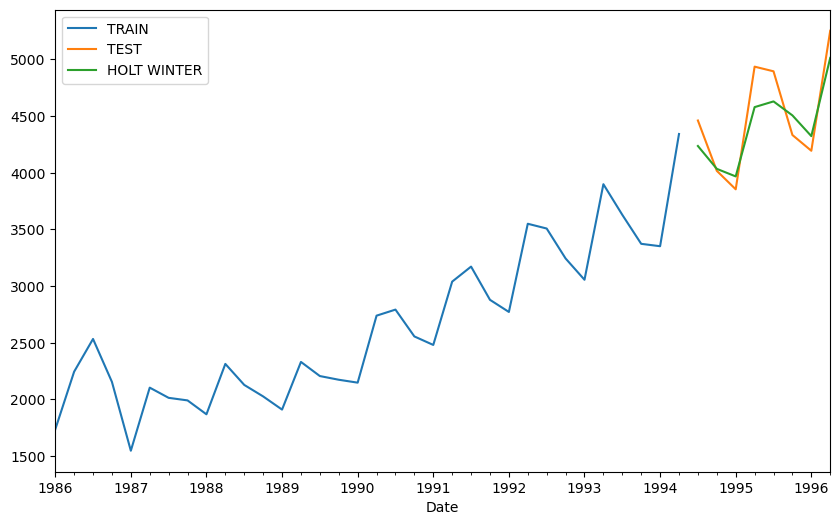

In [499]:
# Plot the train, test and predicted values
train['Sales'].plot(legend = True,label ='TRAIN')
test['Sales'].plot(legend = True,label = 'TEST')
predict_hw_mul_add.plot(legend = True,label = 'HOLT WINTER');

In [500]:
# Calculate RMSE
rmse_hw_mul_add = rmse(test['Sales'],predict_hw_mul_add)
rmse_hw_mul_add

213.9031106738536

In [501]:
test['Sales'].mean()

4492.875

In [502]:
213*100/4493

4.740707767638549

# From the above, we can say that the model is able to capture the trend and seasonality and RMSE of the model is also improved and model performance also improved

# Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [503]:
model_hw_mul_mul = ExponentialSmoothing(train['Sales'],trend = 'mul',seasonal='mul',
                                seasonal_periods=12).fit()
predict_hw_mul_mul = model_hw_mul_mul.predict(test.index[0],test.index[-1])

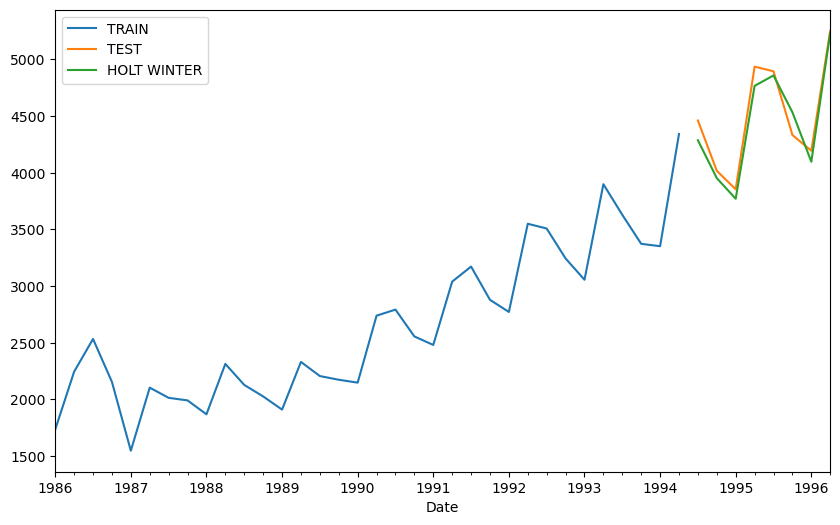

In [504]:
# Plot the train, test and predicted values
train['Sales'].plot(legend = True,label ='TRAIN')
test['Sales'].plot(legend = True,label = 'TEST')
predict_hw_mul_mul.plot(legend = True,label = 'HOLT WINTER');

In [505]:
# Calculate RMSE
rmse_hw_mul_mul = rmse(test['Sales'],predict_hw_mul_mul)
rmse_hw_mul_mul

123.26003099589194

In [506]:
test['Sales'].mean()

4492.875

In [507]:
123.5*100/4493

2.7487202314711774

# The Triple xponential method with multiplicative seasonality and multiplicate trend is giving the best result sofar and the RMSE value of the model also low when compared to other models. On an average the model is not able to predict the 2.8% of the predictions

# Hyper parameter tuning for different smoothing level,trend and seasonal values


Parameters: alpha=0.1, beta=0.1, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        2160426.858
Optimized:                         True   AIC                            408.021
Trend:                   Multiplicative   BIC                            432.443
Seasonal:                Multiplicative   AICC                           453.621
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:02
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

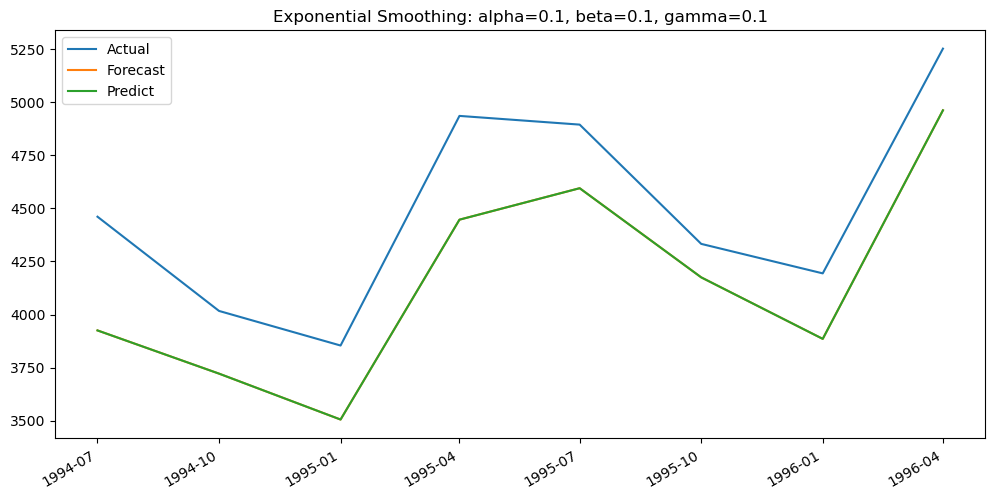


Parameters: alpha=0.1, beta=0.1, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        2167061.557
Optimized:                         True   AIC                            408.126
Trend:                   Multiplicative   BIC                            432.548
Seasonal:                Multiplicative   AICC                           453.726
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:03
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

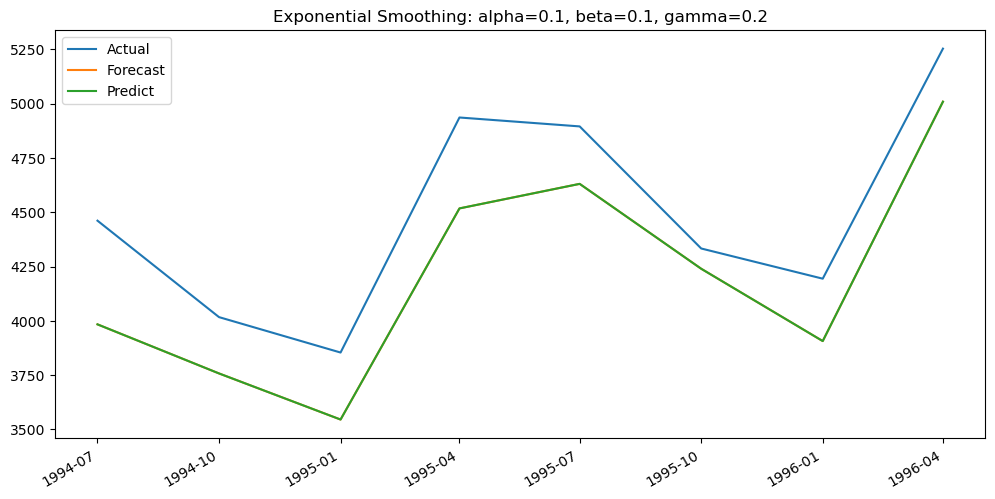


Parameters: alpha=0.1, beta=0.1, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        2178796.622
Optimized:                         True   AIC                            408.309
Trend:                   Multiplicative   BIC                            432.731
Seasonal:                Multiplicative   AICC                           453.909
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

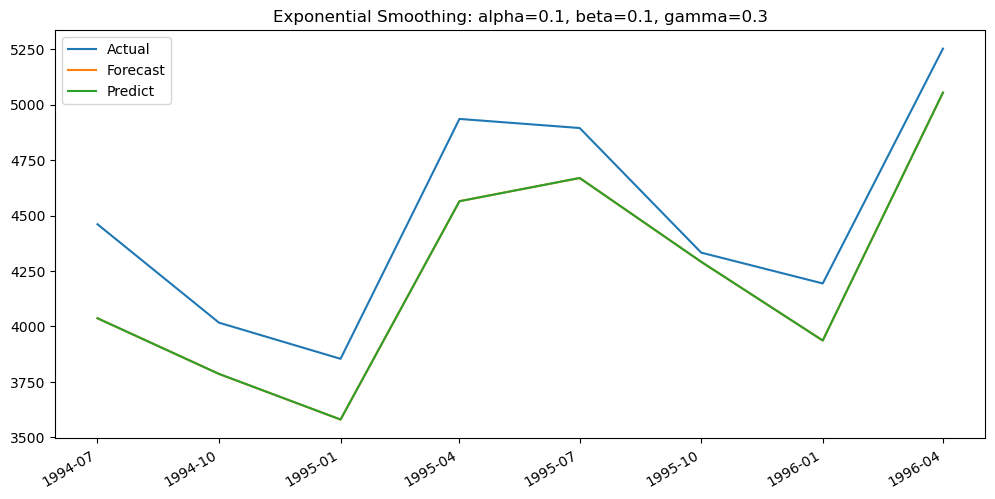


Parameters: alpha=0.1, beta=0.2, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        2451683.231
Optimized:                         True   AIC                            412.321
Trend:                   Multiplicative   BIC                            436.743
Seasonal:                Multiplicative   AICC                           457.921
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:06
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

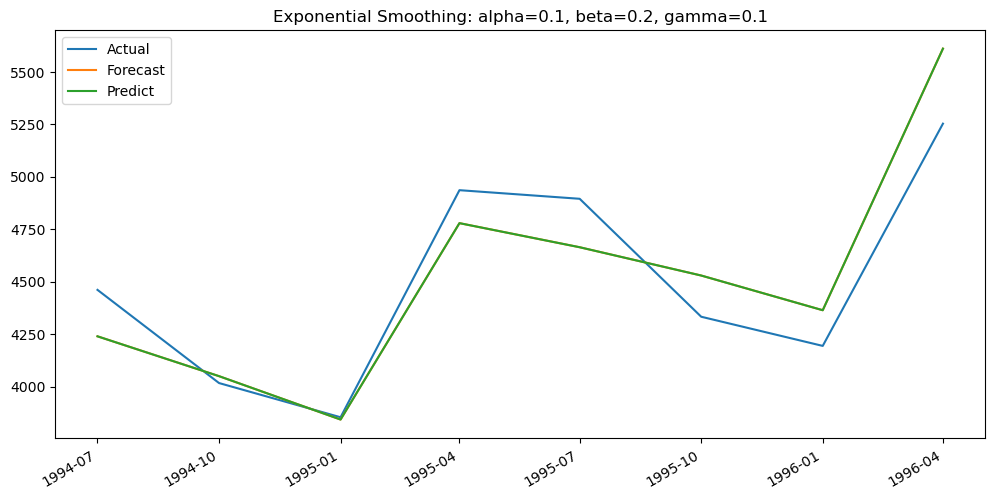


Parameters: alpha=0.1, beta=0.2, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        1811835.985
Optimized:                         True   AIC                            402.039
Trend:                   Multiplicative   BIC                            426.460
Seasonal:                Multiplicative   AICC                           447.639
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:08
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

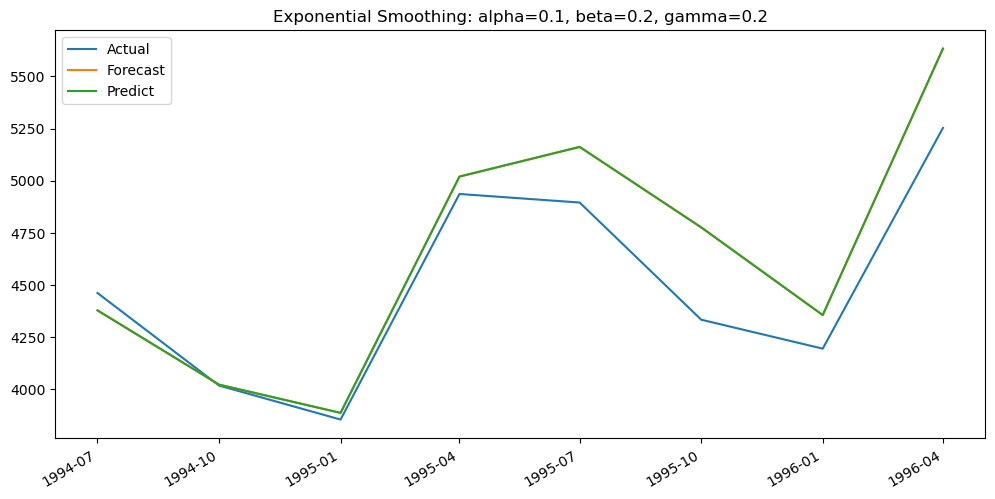


Parameters: alpha=0.1, beta=0.2, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        2419587.389
Optimized:                         True   AIC                            411.873
Trend:                   Multiplicative   BIC                            436.295
Seasonal:                Multiplicative   AICC                           457.473
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:09
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

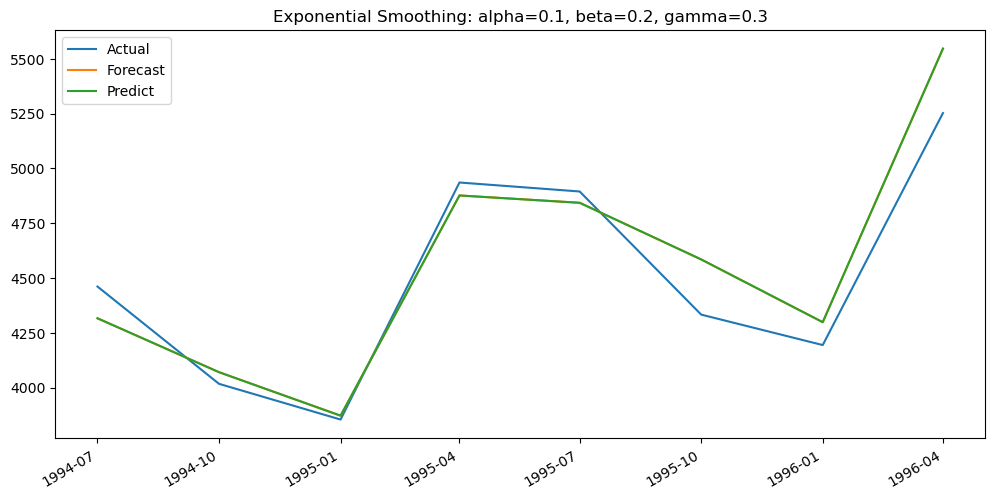


Parameters: alpha=0.1, beta=0.3, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        1933592.352
Optimized:                         True   AIC                            404.250
Trend:                   Multiplicative   BIC                            428.672
Seasonal:                Multiplicative   AICC                           449.850
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:10
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

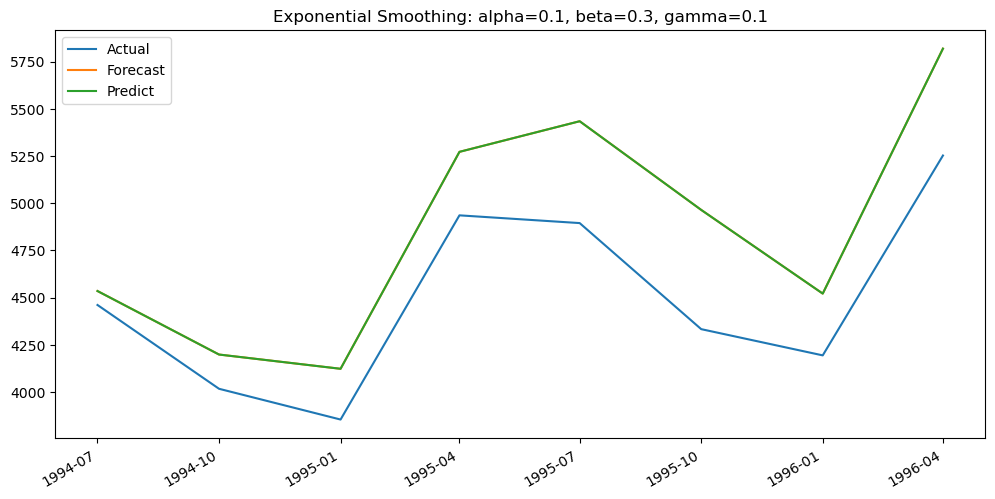


Parameters: alpha=0.1, beta=0.3, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        2060144.965
Optimized:                         True   AIC                            406.405
Trend:                   Multiplicative   BIC                            430.827
Seasonal:                Multiplicative   AICC                           452.005
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:12
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

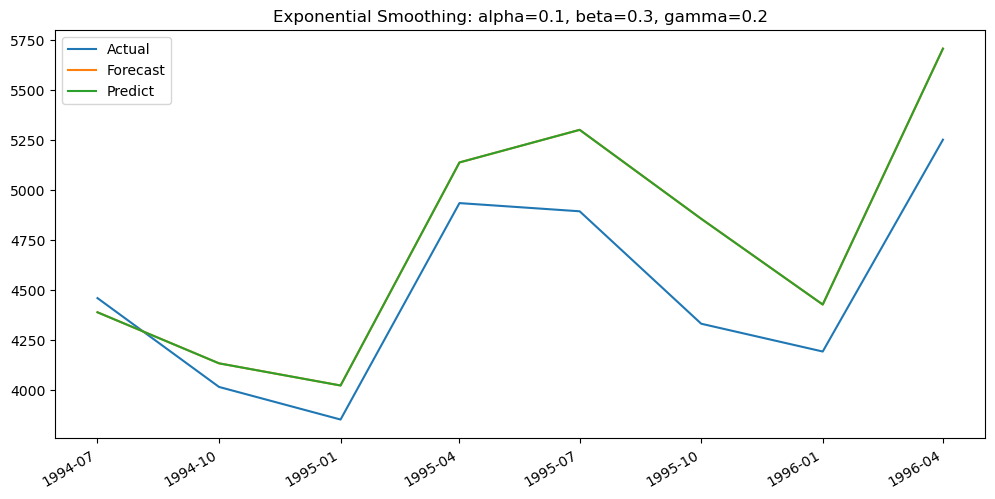


Parameters: alpha=0.1, beta=0.3, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        2133802.784
Optimized:                         True   AIC                            407.600
Trend:                   Multiplicative   BIC                            432.022
Seasonal:                Multiplicative   AICC                           453.200
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:13
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

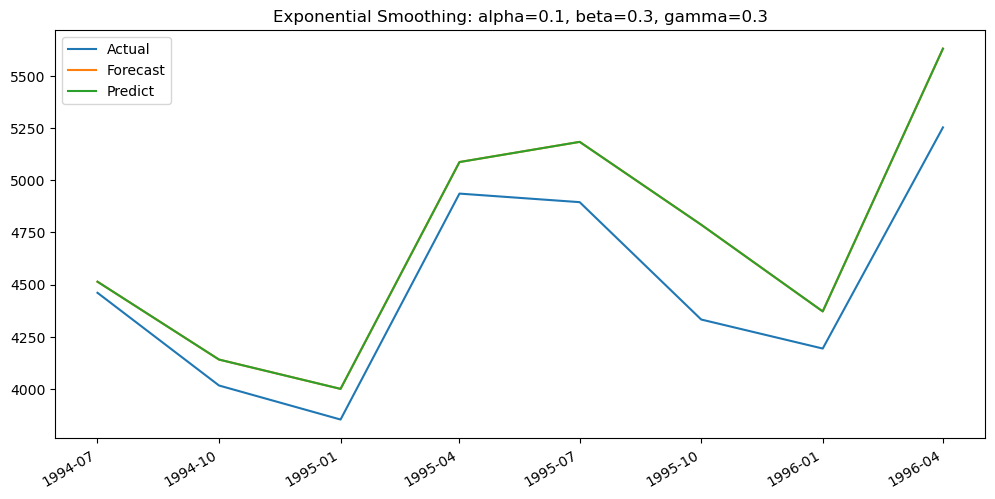


Parameters: alpha=0.2, beta=0.1, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        1171724.697
Optimized:                         True   AIC                            387.219
Trend:                   Multiplicative   BIC                            411.641
Seasonal:                Multiplicative   AICC                           432.819
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:14
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

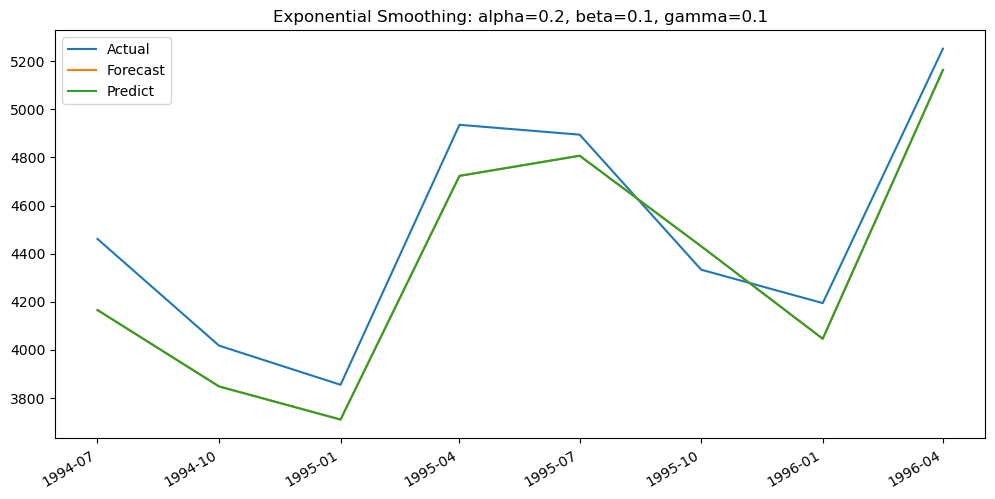


Parameters: alpha=0.2, beta=0.1, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        1211949.866
Optimized:                         True   AIC                            388.367
Trend:                   Multiplicative   BIC                            412.789
Seasonal:                Multiplicative   AICC                           433.967
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:16
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

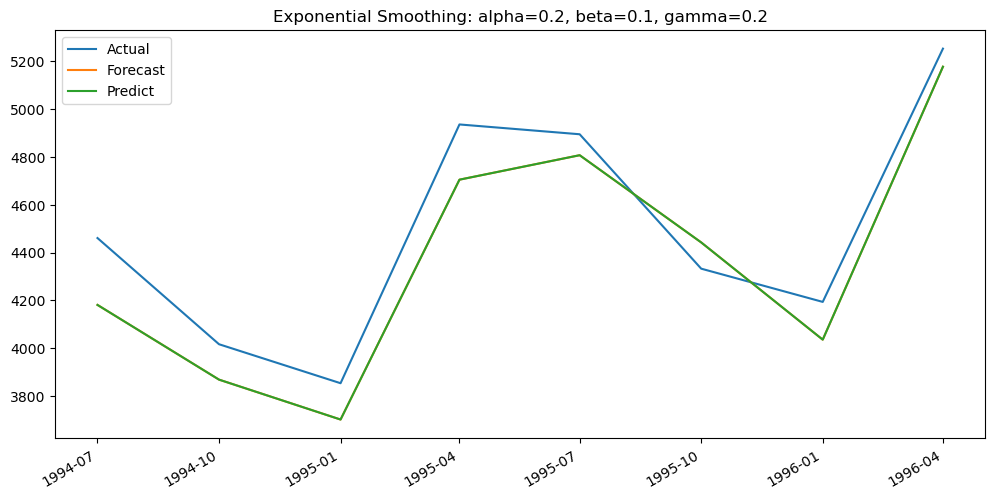


Parameters: alpha=0.2, beta=0.1, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        1310698.737
Optimized:                         True   AIC                            391.030
Trend:                   Multiplicative   BIC                            415.452
Seasonal:                Multiplicative   AICC                           436.630
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:17
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

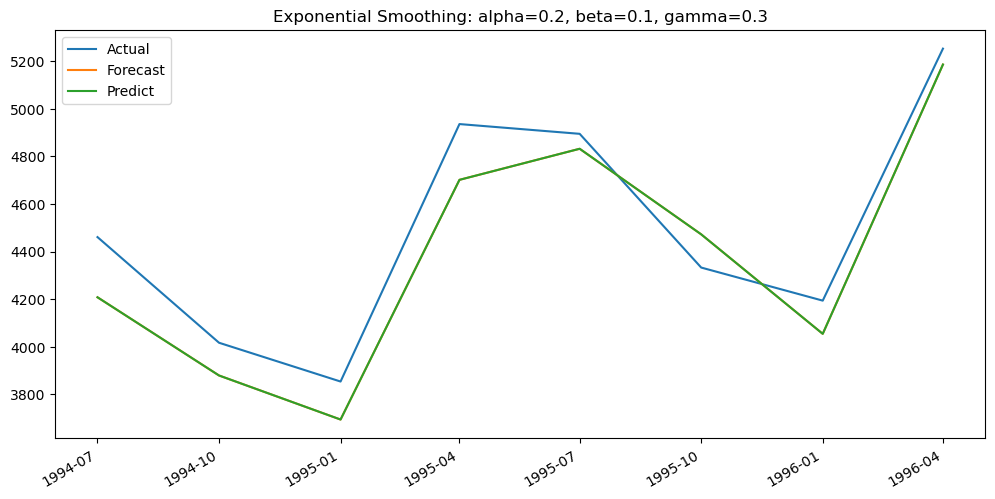


Parameters: alpha=0.2, beta=0.2, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        1231285.607
Optimized:                         True   AIC                            388.905
Trend:                   Multiplicative   BIC                            413.327
Seasonal:                Multiplicative   AICC                           434.505
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:18
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

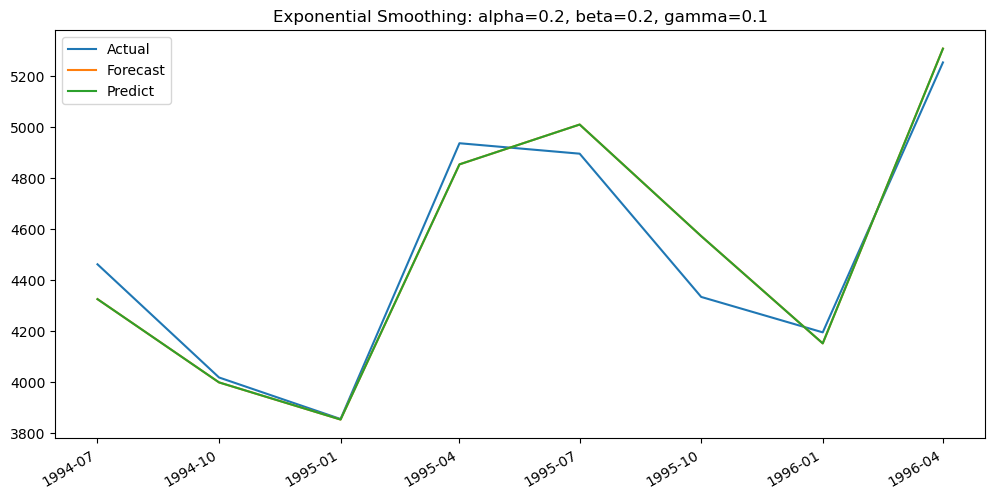


Parameters: alpha=0.2, beta=0.2, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        1130069.954
Optimized:                         True   AIC                            385.989
Trend:                   Multiplicative   BIC                            410.410
Seasonal:                Multiplicative   AICC                           431.589
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:20
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

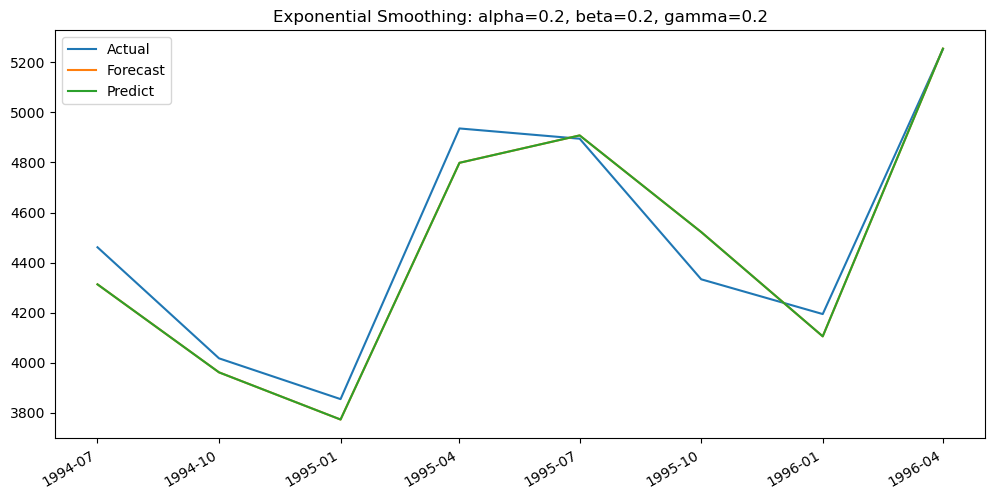


Parameters: alpha=0.2, beta=0.2, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        1396492.678
Optimized:                         True   AIC                            393.186
Trend:                   Multiplicative   BIC                            417.608
Seasonal:                Multiplicative   AICC                           438.786
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

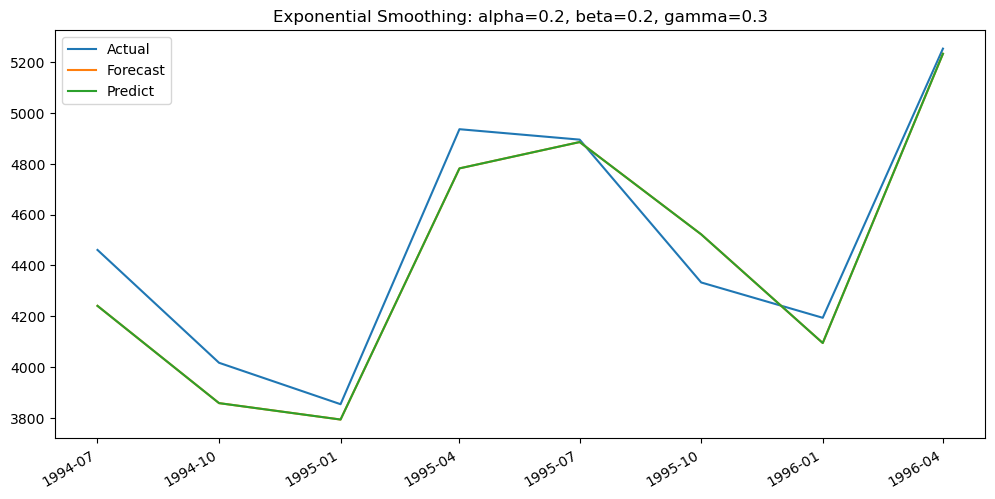


Parameters: alpha=0.2, beta=0.3, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        1166407.218
Optimized:                         True   AIC                            387.065
Trend:                   Multiplicative   BIC                            411.486
Seasonal:                Multiplicative   AICC                           432.665
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:23
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

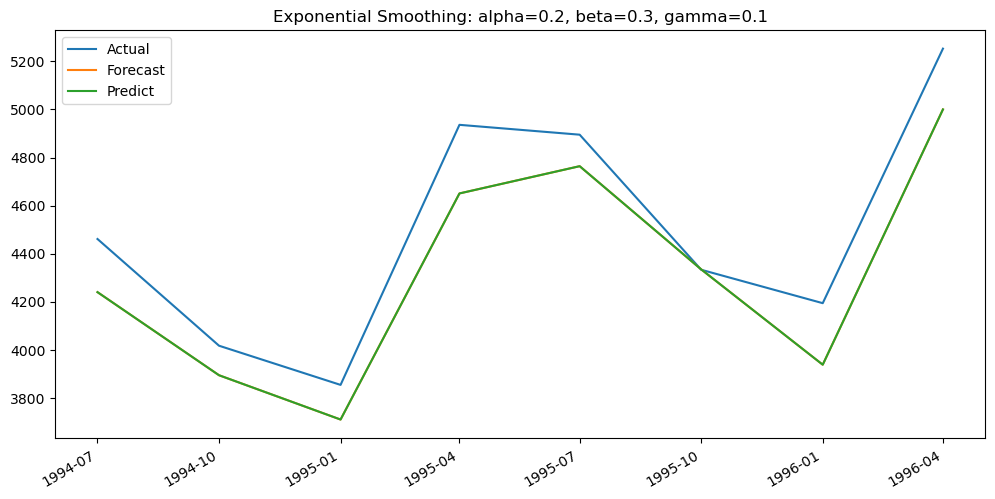


Parameters: alpha=0.2, beta=0.3, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        1313710.403
Optimized:                         True   AIC                            391.108
Trend:                   Multiplicative   BIC                            415.530
Seasonal:                Multiplicative   AICC                           436.708
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:24
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

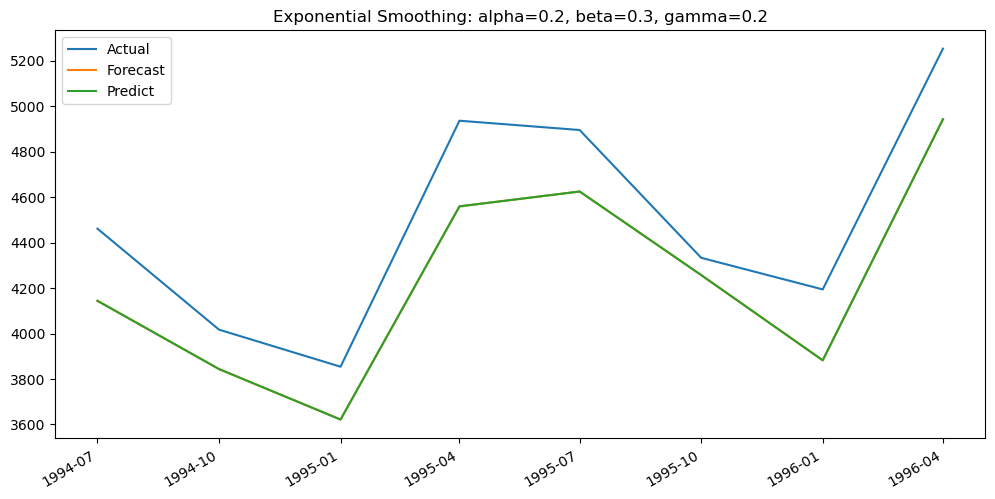


Parameters: alpha=0.2, beta=0.3, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                        1473345.052
Optimized:                         True   AIC                            395.007
Trend:                   Multiplicative   BIC                            419.429
Seasonal:                Multiplicative   AICC                           440.607
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:25
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

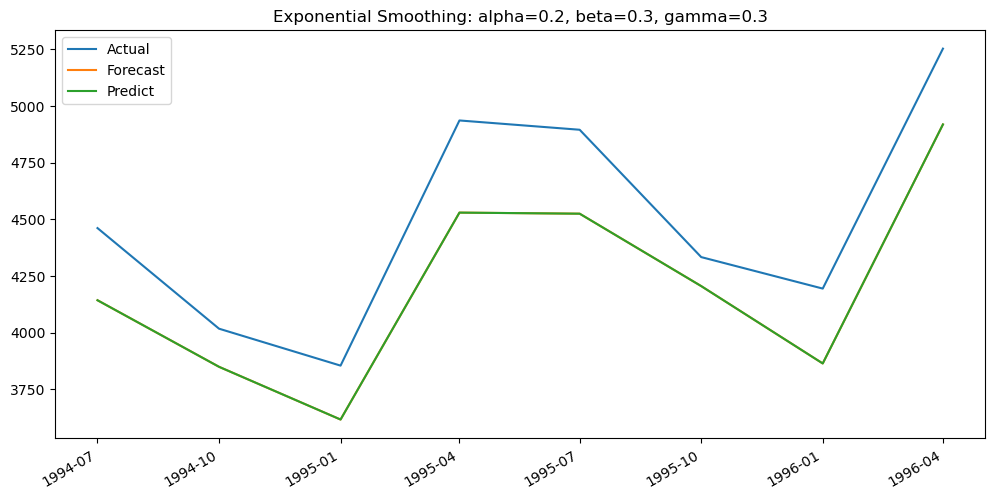


Parameters: alpha=0.3, beta=0.1, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                         818426.820
Optimized:                         True   AIC                            375.018
Trend:                   Multiplicative   BIC                            399.440
Seasonal:                Multiplicative   AICC                           420.618
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:27
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

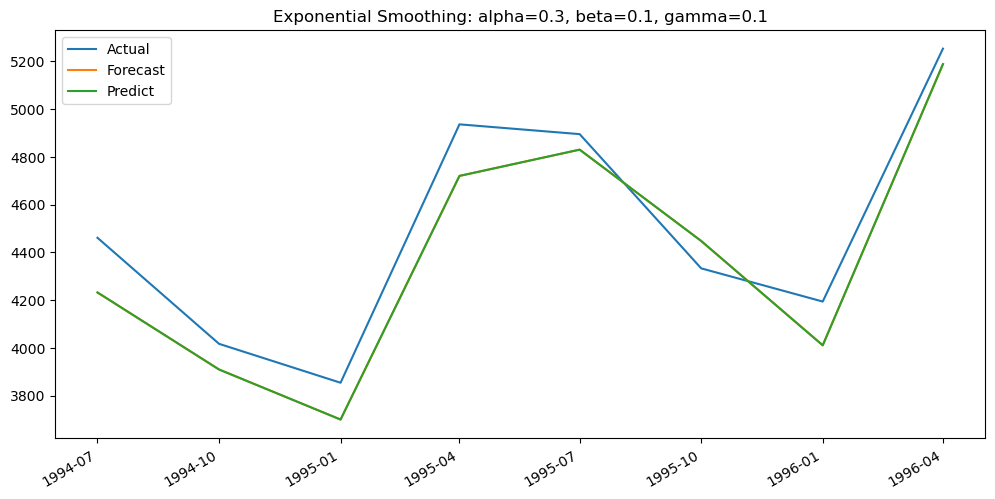


Parameters: alpha=0.3, beta=0.1, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                         862547.738
Optimized:                         True   AIC                            376.804
Trend:                   Multiplicative   BIC                            401.225
Seasonal:                Multiplicative   AICC                           422.404
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:28
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

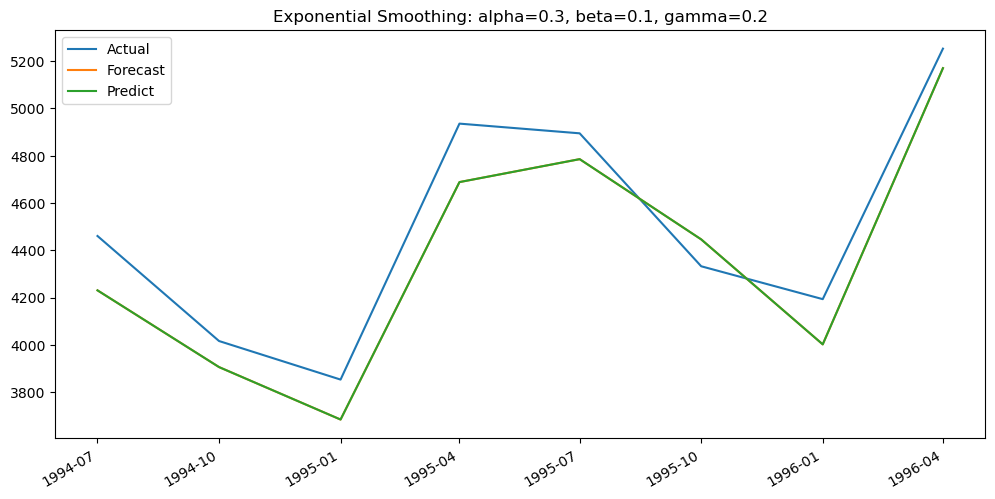


Parameters: alpha=0.3, beta=0.1, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                         909995.807
Optimized:                         True   AIC                            378.624
Trend:                   Multiplicative   BIC                            403.046
Seasonal:                Multiplicative   AICC                           424.224
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:30
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

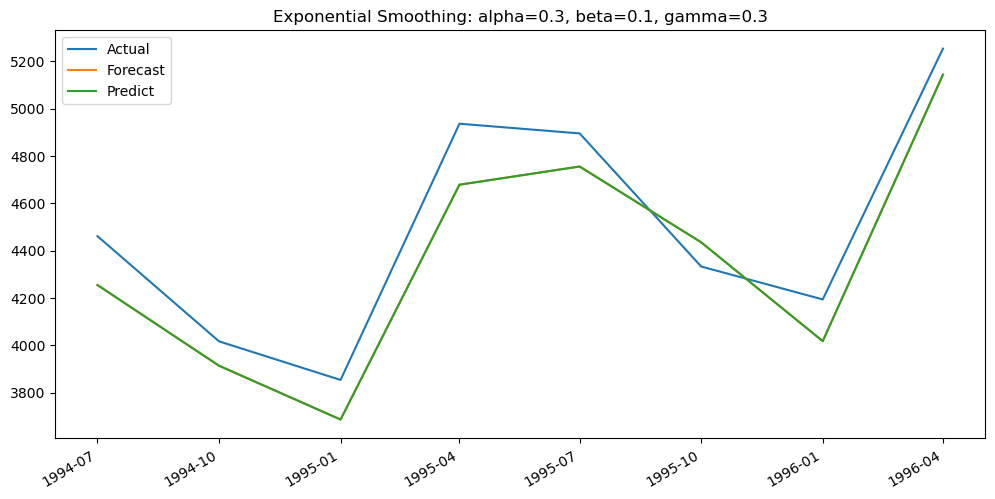


Parameters: alpha=0.3, beta=0.2, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                         799404.004
Optimized:                         True   AIC                            374.219
Trend:                   Multiplicative   BIC                            398.641
Seasonal:                Multiplicative   AICC                           419.819
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:31
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

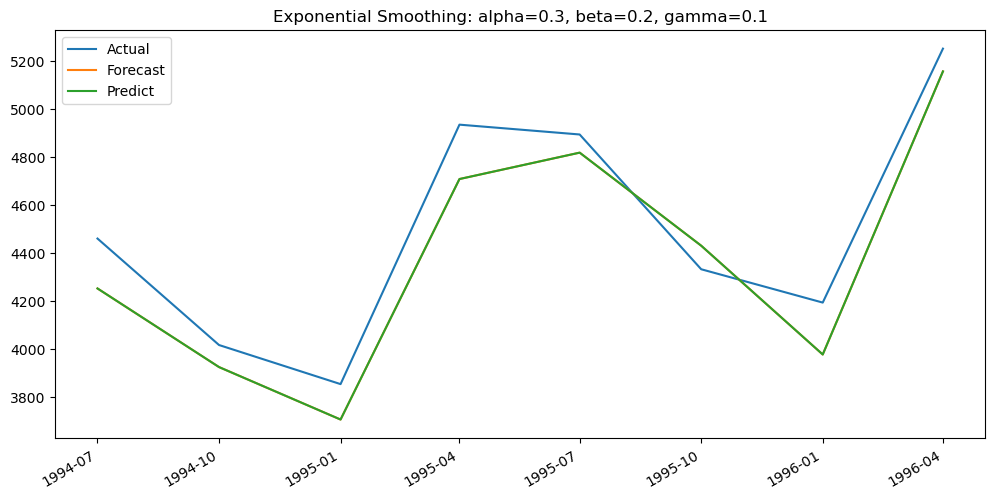


Parameters: alpha=0.3, beta=0.2, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                         846983.776
Optimized:                         True   AIC                            376.185
Trend:                   Multiplicative   BIC                            400.606
Seasonal:                Multiplicative   AICC                           421.785
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:32
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

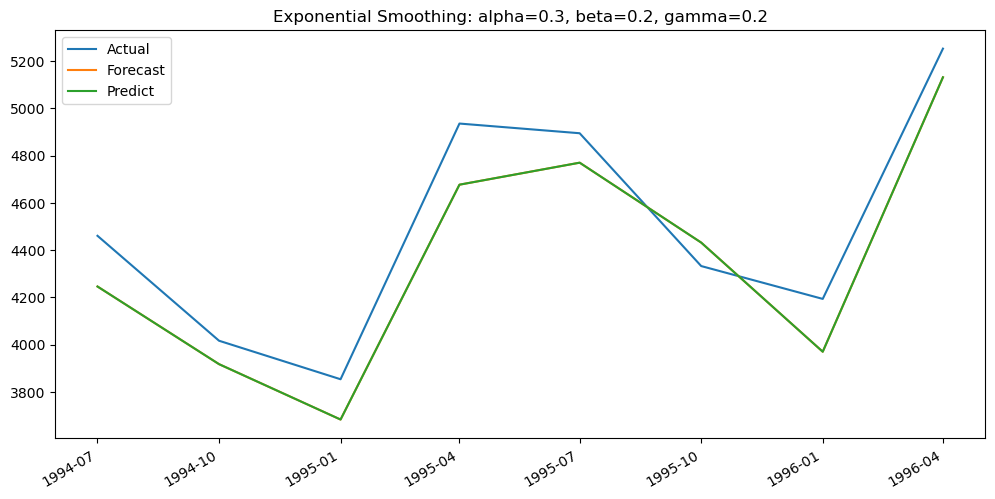


Parameters: alpha=0.3, beta=0.2, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                         889834.230
Optimized:                         True   AIC                            377.863
Trend:                   Multiplicative   BIC                            402.284
Seasonal:                Multiplicative   AICC                           423.463
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:34
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

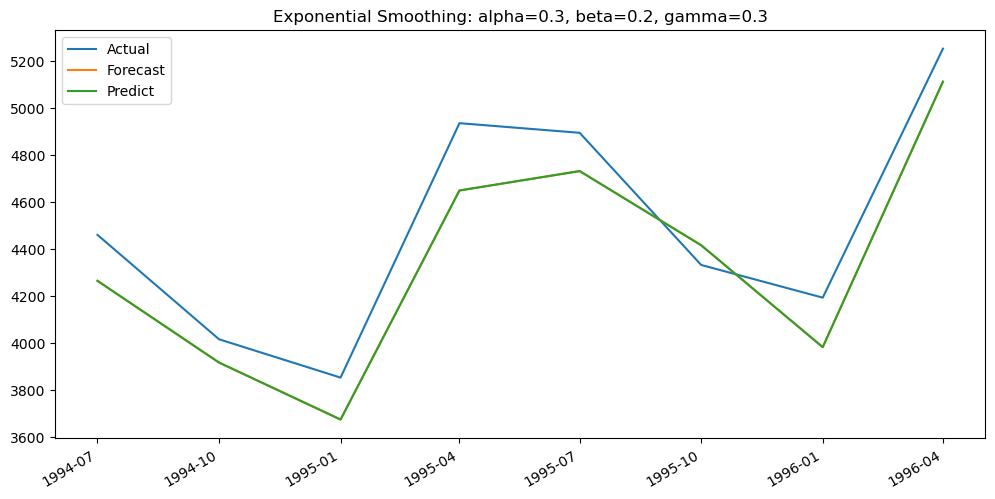


Parameters: alpha=0.3, beta=0.3, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                         772048.076
Optimized:                         True   AIC                            373.035
Trend:                   Multiplicative   BIC                            397.457
Seasonal:                Multiplicative   AICC                           418.635
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:35
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

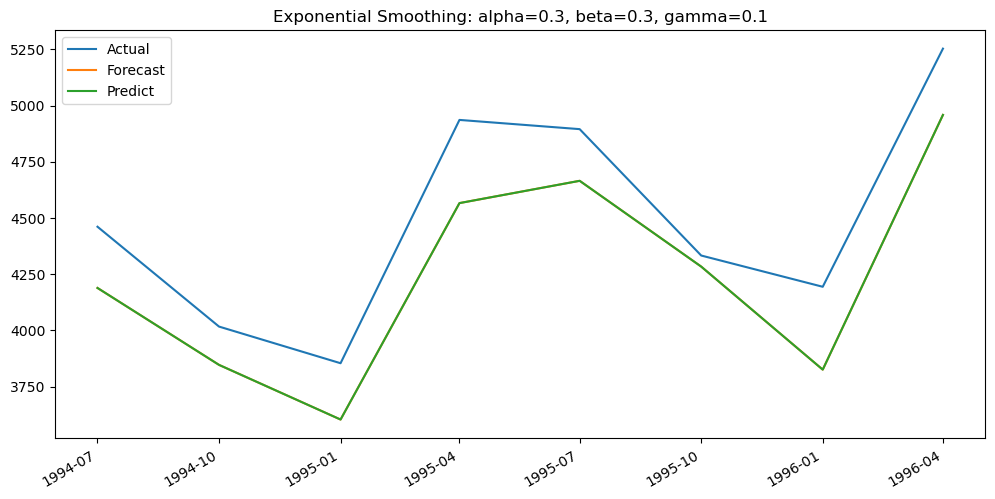


Parameters: alpha=0.3, beta=0.3, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                         830734.044
Optimized:                         True   AIC                            375.526
Trend:                   Multiplicative   BIC                            399.948
Seasonal:                Multiplicative   AICC                           421.126
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:37
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

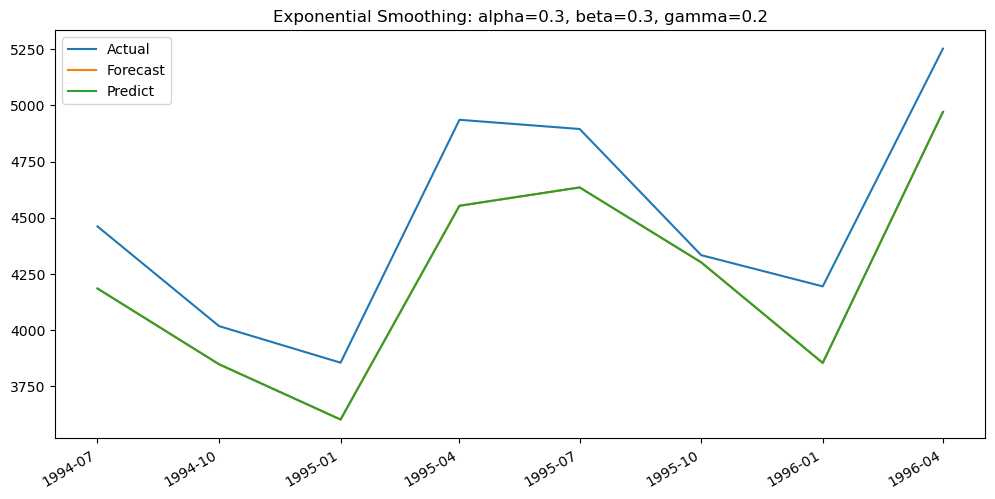


Parameters: alpha=0.3, beta=0.3, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   34
Model:             ExponentialSmoothing   SSE                         884592.403
Optimized:                         True   AIC                            377.662
Trend:                   Multiplicative   BIC                            402.084
Seasonal:                Multiplicative   AICC                           423.262
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         01:31:38
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

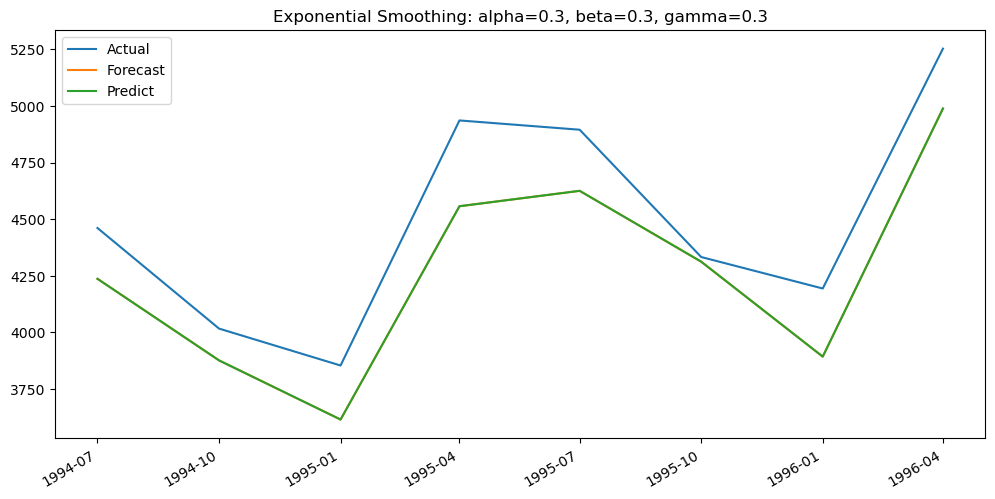

In [338]:
smoothing_level_values = [0.1, 0.2, 0.3]
smoothing_trend_values = [0.1, 0.2, 0.3]
smoothing_seasonal_values = [0.1, 0.2, 0.3]

# Perform Exponential Smoothing with different parameter values
for alpha in smoothing_level_values:
    for beta in smoothing_trend_values:
        for gamma in smoothing_seasonal_values:
            model = ExponentialSmoothing(train['Sales'], trend='mul', seasonal='mul', 
                                         seasonal_periods=12, 
                                         use_boxcox=False)
            result = model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
            # Print model summary
            print(f"\nParameters: alpha={alpha}, beta={beta}, gamma={gamma}")
            print(result.summary())
            predict_1 = result.predict(start = test.index[0],end = test.index[-1])
            forecast = result.forecast(len(test.index))
            plt.figure(figsize=(12, 6))
            plt.plot(test['Sales'], label='Actual')
            plt.plot(forecast, label='Forecast')
            predict_1.plot(label = 'Predict',legend =True)
            plt.title(f'Exponential Smoothing: alpha={alpha}, beta={beta}, gamma={gamma}')
            plt.legend()
            plt.show()

In [517]:
model_test = ExponentialSmoothing(train['Sales'],seasonal='mul',trend = 'mul',
                                seasonal_periods=12).fit(smoothing_level = 0.2,smoothing_trend = 0.2,smoothing_seasonal = 0.2)
model_predict = model_test.predict(test.index[0],test.index[-1])

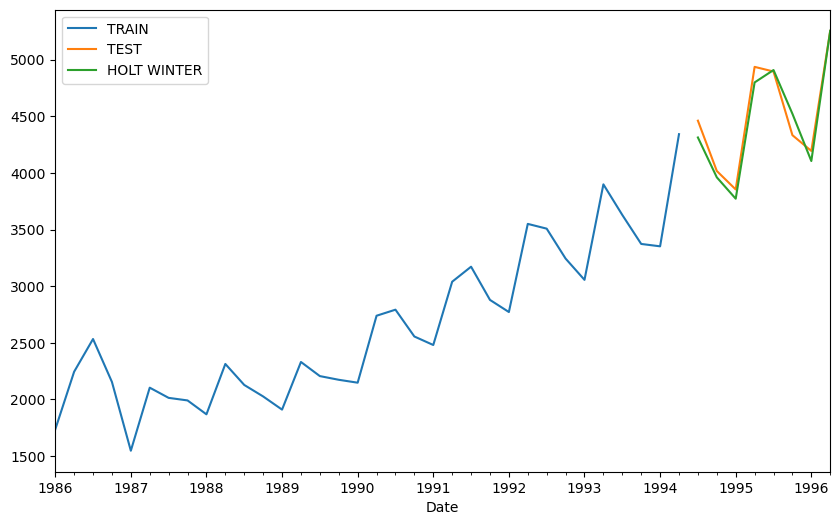

In [518]:
# Plot the train, test and predicted values
train['Sales'].plot(legend = True,label ='TRAIN')
test['Sales'].plot(legend = True,label = 'TEST')
model_predict.plot(legend = True,label = 'HOLT WINTER');

In [519]:
# Calculate RMSE
rmse_model = rmse(test['Sales'],model_predict)
rmse_model

108.66234524126122

In [342]:
test['Sales'].mean()

4492.875

In [520]:
108*100/4493

2.40373914978856

# So far the Holt winter method with multiplicative seasonality and trend, smoothing_level = 0.2,smoothing_trend = 0.2,smoothing_seasonal = 0.2 is giving the best result

In [521]:
rmse_df = pd.DataFrame({'Model':['Simple exp',
                                'Double Exp',
                                'Tri exp Add_Add',
                                'Tri exp Add_Mul',
                                'Tri exp Mul_Add',
                                'Tri exp Mul_Mul',
                                'Tri exp Mul_Mul_hyp'],
                       'RMSE':[rmse_ses,rmse_holt,rmse_hw_add,rmse_hw_add_mul,
                               rmse_hw_mul_add,rmse_hw_mul_mul,rmse_model]})

In [522]:
rmse_df.sort_values(by='RMSE',ascending=True)

Model        RMSE
6  Tri exp Mul_Mul_hyp  108.662345
5      Tri exp Mul_Mul  123.260031
4      Tri exp Mul_Add  213.903111
2      Tri exp Add_Add  330.080000
3      Tri exp Add_Mul  388.613969
1           Double Exp  459.780097
0           Simple exp  786.835986

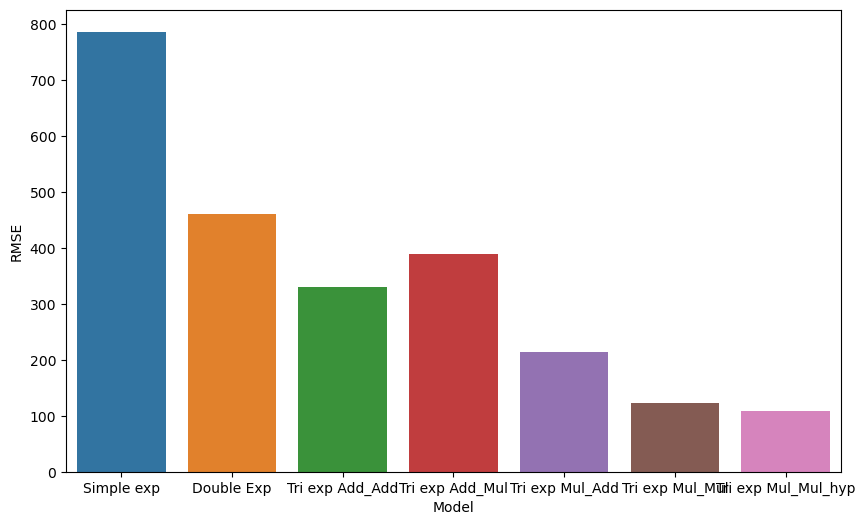

In [523]:
sns.barplot(data = rmse_df , x = 'Model', y = 'RMSE' );

# So far the triple exponential smoothing model with multiplicative seasonality and trend and smoothing_level =0.2,smoothing_trend=0.2,smoothing_seasonal = 0.2 is giving the best result

# Autoregressive Integrated Moving Averages (ARIMA)

In [524]:
# import adfuller
from statsmodels.tsa.stattools import adfuller

In [525]:
# Check for stationarity using the Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=4).mean()
    rolling_std = timeseries.rolling(window=4).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Dickey-Fuller test
    result = adfuller(timeseries['Sales'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])


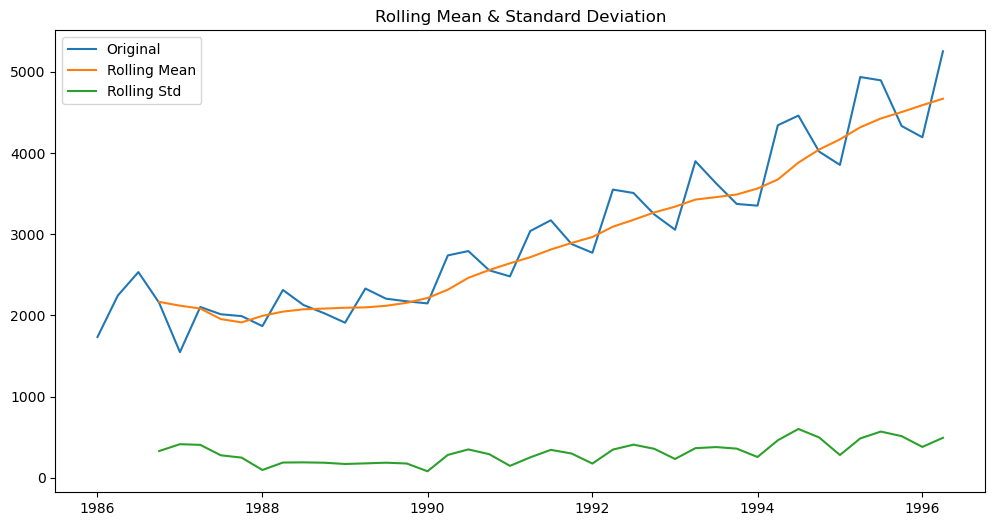

ADF Statistic: 1.309421015326809
p-value: 0.9966611673930905
Critical Values: {'1%': -3.639224104416853, '5%': -2.9512301791166293, '10%': -2.614446989619377}


In [526]:
test_stationarity(df)

# As p value is 0.99 , that is greater than the significance level, the data is not stationery

# Check for stationery with time series difference of 1

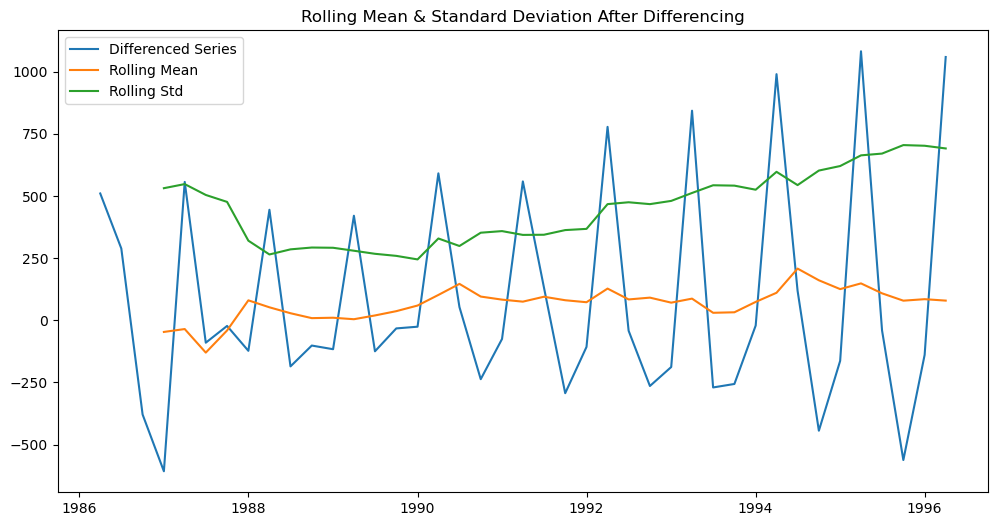

ADF Statistic: -2.501537002033795
p-value: 0.11510080332405642
Critical Values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}


In [527]:
# Check for stationarity using the Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    # Perform differencing
    timeseries_diff = timeseries.diff().dropna()

    # Rolling statistics
    rolling_mean = timeseries_diff.rolling(window=4).mean()
    rolling_std = timeseries_diff.rolling(window=4).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries_diff, label='Differenced Series')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation After Differencing')
    plt.show()

    # Dickey-Fuller test
    result = adfuller(timeseries_diff['Sales'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

test_stationarity(df)

# The p value is greater than the significance level, The data is not stationery

# Check for stationery of time series with time series difference of 2

In [528]:
timeseries_diff2 = df.diff().diff().dropna()

# Check for stationarity using the Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=4).mean()
    rolling_std = timeseries.rolling(window=4).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Second Differenced Series')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation After Second Differencing')
    plt.show()

    # Dickey-Fuller test
    result = adfuller(timeseries['Sales'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

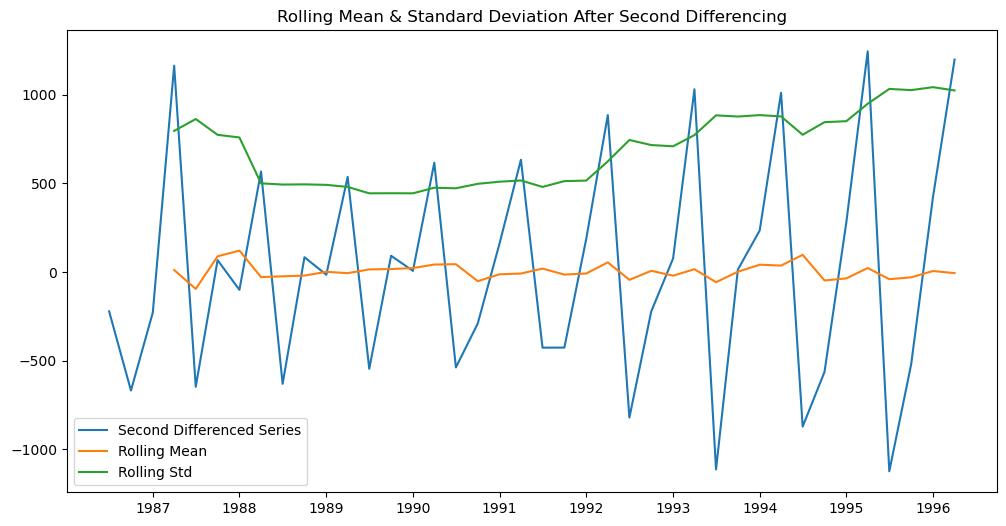

ADF Statistic: -27.632624946381696
p-value: 0.0
Critical Values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}


In [529]:
test_stationarity(timeseries_diff2)

# The p value is almost 0 , it means we can reject the null hypothesis and the data is stationery

In [530]:
print(timeseries_diff2)

                  Sales
Date                   
1986-07-01  -221.290005
1986-10-01  -667.685989
1987-01-01  -228.302006
1987-04-01  1163.737000
1987-07-01  -646.641994
1987-10-01    67.432995
1988-01-01  -100.080997
1988-04-01   567.278996
1988-07-01  -629.893993
1988-10-01    83.820995
1989-01-01   -14.734001
1989-04-01   536.785999
1989-07-01  -545.175995
1989-10-01    92.032997
1990-01-01     6.892006
1990-04-01   616.719994
1990-07-01  -537.584000
1990-10-01  -290.190002
1991-01-01   161.708008
1991-04-01   633.584991
1991-07-01  -425.955994
1991-10-01  -425.708000
1992-01-01   186.113998
1992-04-01   885.000999
1992-07-01  -820.000000
1992-10-01  -222.140007
1993-01-01    76.280014
1993-04-01  1030.859993
1993-07-01 -1113.000000
1993-10-01    14.000000
1994-01-01   235.000000
1994-04-01  1011.000000
1994-07-01  -871.000000
1994-10-01  -563.000000
1995-01-01   281.000000
1995-04-01  1245.000000
1995-07-01 -1123.000000
1995-10-01  -521.000000
1996-01-01   423.000000
1996-04-01  1198

In [531]:
timeseries_diff2.head()

Sales
Date                   
1986-07-01  -221.290005
1986-10-01  -667.685989
1987-01-01  -228.302006
1987-04-01  1163.737000
1987-07-01  -646.641994

In [532]:
timeseries_diff2.shape

(40, 1)

In [533]:
train = timeseries_diff2.iloc[:32]
test = timeseries_diff2.iloc[32:]

In [534]:
train.shape,test.shape

((32, 1), (8, 1))

In [535]:
train.head()

Sales
Date                   
1986-07-01  -221.290005
1986-10-01  -667.685989
1987-01-01  -228.302006
1987-04-01  1163.737000
1987-07-01  -646.641994

In [536]:
train.tail()

Sales
Date                   
1993-04-01  1030.859993
1993-07-01 -1113.000000
1993-10-01    14.000000
1994-01-01   235.000000
1994-04-01  1011.000000

In [537]:
test.head()

Sales
Date              
1994-07-01  -871.0
1994-10-01  -563.0
1995-01-01   281.0
1995-04-01  1245.0
1995-07-01 -1123.0

In [538]:
test.tail()

Sales
Date              
1995-04-01  1245.0
1995-07-01 -1123.0
1995-10-01  -521.0
1996-01-01   423.0
1996-04-01  1198.0

# ARIMA model Hyper parameter tuning

In [539]:
# Arima model parameter tuning using auto_arima
from pmdarima import auto_arima

In [540]:
# Implement auto_arima to find the best parameters for value 0 to 3 for p and q
auto_arima_no_season = auto_arima(train['Sales'],start_p=0,start_q=0,d = 1,max_p=3,max_q=3,
                                  seasonal=False,stepwise=False,trace=True)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=514.008, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=505.872, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=504.485, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=493.008, Time=1.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=435.400, Time=0.98 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 10

In [541]:
# Fit the model with the identified best parameters
arima_311 = ARIMA(train['Sales'],order=(3,1,1))
result_311 = arima_311.fit()
forecast_311 = result_311.predict(start = len(train),end = len(train)+len(test)-1).rename('ARIMA (3,1,1) PREDICTIONS')

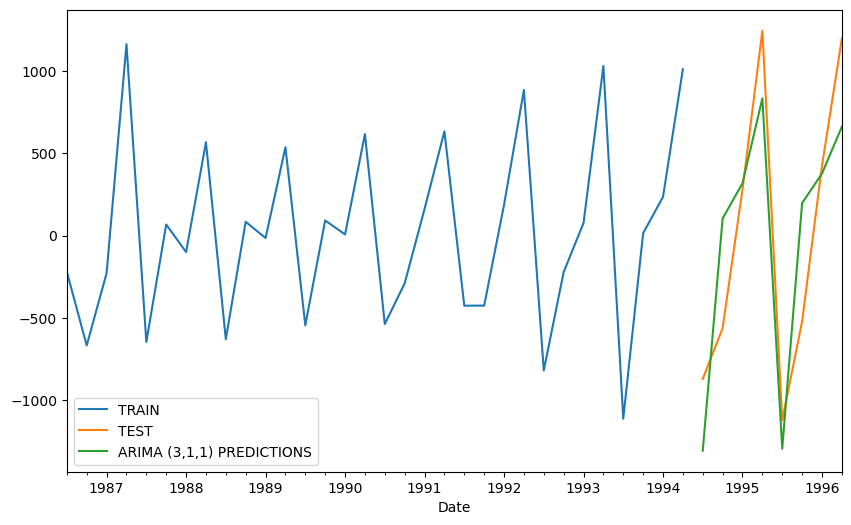

In [542]:
# Plot the train, test , forecast data
train['Sales'].plot(legend = True , label = 'TRAIN')
test['Sales'].plot(legend = True,label='TEST')
forecast_311.plot(legend = True);

In [543]:
rmse_311 = rmse(test['Sales'],forecast_311)

In [544]:
rmse_311

452.84879154392536

# The model performance is good but we should not compare it with the Holt Winter method as it can not capture the seasonality

# SARIMA MODEL With best parameters

In [545]:
model_sarima = SARIMAX(train['Sales'],order = (1,1,1),seasonal_order=(1,1,1,12))
results_sarima = model_sarima.fit()
forecast_sarima = results_sarima.predict(start = len(train),end = len(train)+len(test)-1).rename('SARIMA Forecast')
forecast_sarima

1994-07-01   -597.198144
1994-10-01   -124.227201
1995-01-01    112.108635
1995-04-01    820.667369
1995-07-01   -799.129428
1995-10-01    145.223419
1996-01-01    175.550378
1996-04-01    706.395761
Freq: QS-OCT, Name: SARIMA Forecast, dtype: float64

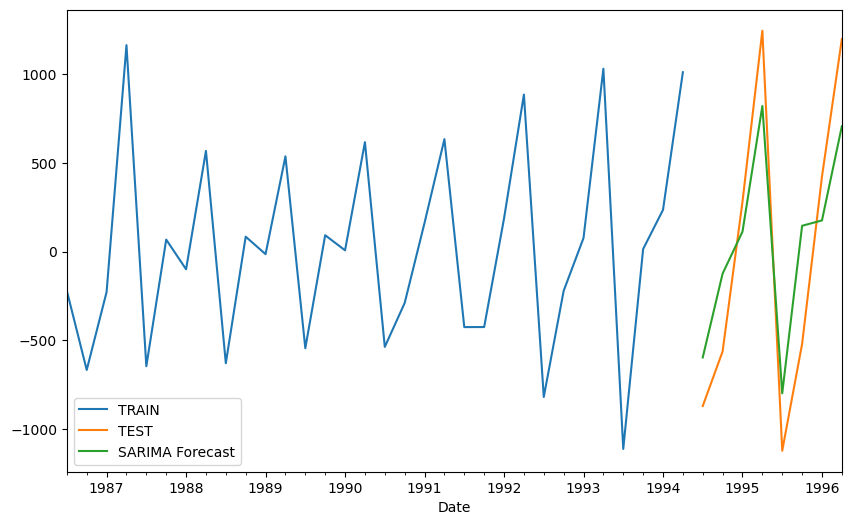

In [546]:
# Plot the train ,test and forecast values
train['Sales'].plot(legend = True,label='TRAIN')
test['Sales'].plot(legend = True,label = 'TEST')
forecast_sarima.plot(legend = True);

In [547]:
rmse_sarima = rmse(test['Sales'],forecast_sarima)
rmse_sarima

407.3885329791312

# We can do hyperparameter tuning as follows fro p,q,d and P,Q,D values

In [ ]:
# Try with different values of p and q from 1 to 3 and seasonal is true and m = 12
auto_arima_model = auto_arima(train['Sales'],start_p=1,start_q=1,max_p=3,max_q=3,d = 1,max_d= 3 ,seasonal=True,trace=True,
                              stepwise=False,start_P = 0 ,max_P= 3 ,D = 1 ,max_D = 3 , m = 12,start_Q = 0, max_Q =3)

# The SARIMA model is able to capture the trend an seasonality and RMSE values is less when compared to ARIMA model. But the model performance is not upto the mark

# Forecast by Base Models

# Data preprocessing for Base Models

In [548]:
df.reset_index(inplace=True)
df['t'] = np.arange(1,len(df)+1)
df['t_squared'] = np.square(df.t)
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(df['month'])
months = months[['Jan','Apr','Jul','Oct']]
cocacola = pd.concat([df,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola.head()

Date        Sales  t  t_squared month  year  Jan  Apr  Jul  Oct  \
0 1986-01-01  1734.827000  1          1   Jan  1986    1    0    0    0   
1 1986-04-01  2244.960999  2          4   Apr  1986    0    1    0    0   
2 1986-07-01  2533.804993  3          9   Jul  1986    0    0    1    0   
3 1986-10-01  2154.962997  4         16   Oct  1986    0    0    0    1   
4 1987-01-01  1547.818996  5         25   Jan  1987    1    0    0    0   

   log_sales  
0   7.458663  
1   7.716443  
2   7.837477  
3   7.675529  
4   7.344602

In [549]:
cocacola.set_index('Date',inplace = True)

In [550]:
cocacola.head()

Sales  t  t_squared month  year  Jan  Apr  Jul  Oct  \
Date                                                                    
1986-01-01  1734.827000  1          1   Jan  1986    1    0    0    0   
1986-04-01  2244.960999  2          4   Apr  1986    0    1    0    0   
1986-07-01  2533.804993  3          9   Jul  1986    0    0    1    0   
1986-10-01  2154.962997  4         16   Oct  1986    0    0    0    1   
1987-01-01  1547.818996  5         25   Jan  1987    1    0    0    0   

            log_sales  
Date                   
1986-01-01   7.458663  
1986-04-01   7.716443  
1986-07-01   7.837477  
1986-10-01   7.675529  
1987-01-01   7.344602

In [551]:
# PIVOT TABLE
cocacola_pivot = cocacola.pivot_table(values = 'Sales', index = 'year' , columns = 'month')
cocacola_pivot

month          Apr          Jan          Jul          Oct
year                                                     
1986   2244.960999  1734.827000  2533.804993  2154.962997
1987   2104.411995  1547.818996  2014.362999  1991.746998
1988   2313.631996  1869.049999  2128.320000  2026.828999
1989   2331.164993  1910.603996  2206.549995  2173.967995
1990   2739.307999  2148.278000  2792.753998  2556.009995
1991   3039.522995  2480.973999  3172.115997  2879.000999
1992   3550.000000  2772.000000  3508.000000  3243.859993
1993   3899.000000  3056.000000  3629.000000  3373.000000
1994   4342.000000  3352.000000  4461.000000  4017.000000
1995   4936.000000  3854.000000  4895.000000  4333.000000
1996   5253.000000  4194.000000          NaN          NaN

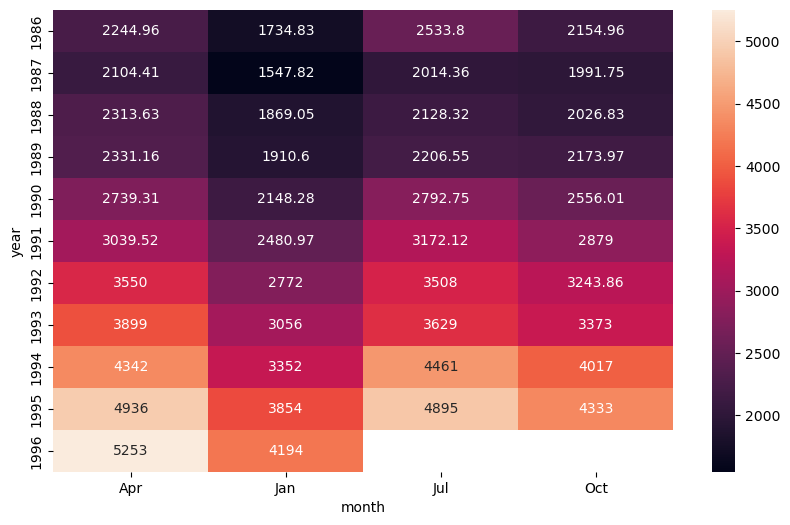

In [552]:
# Heat map visualization 
sns.heatmap(cocacola_pivot , annot =True, fmt='g');

In [553]:
len(cocacola)

42

In [554]:
train = cocacola.iloc[:34]
test = cocacola.iloc[34:]

In [555]:
train.shape,test.shape

((34, 10), (8, 10))

In [556]:
train.head()

Sales  t  t_squared month  year  Jan  Apr  Jul  Oct  \
Date                                                                    
1986-01-01  1734.827000  1          1   Jan  1986    1    0    0    0   
1986-04-01  2244.960999  2          4   Apr  1986    0    1    0    0   
1986-07-01  2533.804993  3          9   Jul  1986    0    0    1    0   
1986-10-01  2154.962997  4         16   Oct  1986    0    0    0    1   
1987-01-01  1547.818996  5         25   Jan  1987    1    0    0    0   

            log_sales  
Date                   
1986-01-01   7.458663  
1986-04-01   7.716443  
1986-07-01   7.837477  
1986-10-01   7.675529  
1987-01-01   7.344602

In [557]:
train.tail()

Sales   t  t_squared month  year  Jan  Apr  Jul  Oct  log_sales
Date                                                                        
1993-04-01  3899.0  30        900   Apr  1993    0    1    0    0   8.268475
1993-07-01  3629.0  31        961   Jul  1993    0    0    1    0   8.196712
1993-10-01  3373.0  32       1024   Oct  1993    0    0    0    1   8.123558
1994-01-01  3352.0  33       1089   Jan  1994    1    0    0    0   8.117312
1994-04-01  4342.0  34       1156   Apr  1994    0    1    0    0   8.376090

In [558]:
test.head()

Sales   t  t_squared month  year  Jan  Apr  Jul  Oct  log_sales
Date                                                                        
1994-07-01  4461.0  35       1225   Jul  1994    0    0    1    0   8.403128
1994-10-01  4017.0  36       1296   Oct  1994    0    0    0    1   8.298291
1995-01-01  3854.0  37       1369   Jan  1995    1    0    0    0   8.256867
1995-04-01  4936.0  38       1444   Apr  1995    0    1    0    0   8.504311
1995-07-01  4895.0  39       1521   Jul  1995    0    0    1    0   8.495970

In [559]:
test.tail()

Sales   t  t_squared month  year  Jan  Apr  Jul  Oct  log_sales
Date                                                                        
1995-04-01  4936.0  38       1444   Apr  1995    0    1    0    0   8.504311
1995-07-01  4895.0  39       1521   Jul  1995    0    0    1    0   8.495970
1995-10-01  4333.0  40       1600   Oct  1995    0    0    0    1   8.374015
1996-01-01  4194.0  41       1681   Jan  1996    1    0    0    0   8.341410
1996-04-01  5253.0  42       1764   Apr  1996    0    1    0    0   8.566555

# Base Forecasting models

# Linear regression, Since the target variable is numeric

In [560]:
 # fit a linear model on the train dataset with footfalls as the target variable and t as the feature
model_linear = ols('Sales~t', data = train).fit()

In [561]:
# Predicting foot fall
pred = model_linear.predict(test['t'])

In [562]:
# Calculate the RMSE
rmse_lin = rmse(test['Sales'],pred)
print('RMSE of Linear Model', rmse_lin)

RMSE of Linear Model 720.6137817965252


# Exponential model

In [563]:
# fit a model with log_footfalls as the target variable and t as the feature
model_exp = ols('log_sales~t',data = train).fit()

In [564]:
# Predict the target varible and Print Rmse
pred = model_exp.predict(test['t'])
rmse_exp = rmse(test['Sales'],np.exp(pred))
print('RMSE value of Exp model:',rmse_exp)

RMSE value of Exp model: 564.985093727415


# QUADRATIC MODEL

In [565]:
model_quad = ols('Sales~t+I(t**2)',data = train).fit()

In [566]:
pred = model_quad.predict(test[['t','t_squared']])
rmse_quad = rmse(test['Sales'],pred)
print('RMSE value of Quad model:',rmse_quad)

RMSE value of Quad model: 437.74556375585945


# Additive Seasonality Model

In [567]:
model_add_sea = ols('Sales~Jan+Apr+Jul+Oct',data = train).fit()

In [568]:
# Predict the target variable and print the rmse
pred = model_add_sea.predict(test[['Jan','Apr','Jul','Oct']])
rmse_add_sea = rmse(test['Sales'],pred)
print('RMSE value of Additive model:',rmse_add_sea)

RMSE value of Additive model: 1870.1899069853296


# Quadratic Model with Additive Seasonality

In [569]:
# fit a model with footfalls as the target with the months and t and t_square as the features
model_qua_add = ols('Sales~Jan+Apr+Jul+Oct+t+I(t**2)',data = train).fit()

In [570]:
# Predict the target variable and print the rmse
pred = model_qua_add.predict(test[['Jan','Apr','Jul','Oct','t','t_squared']])
rmse_qua_add = rmse(test['Sales'],pred)
print('RMSE value of Quad add model :', rmse_qua_add)

RMSE value of Quad add model : 257.6717256536286


# Multiplicative Seasonality Model

In [571]:
# fit a model with log_footfalls as the target with months as the features
model_multi = ols('log_sales~Jan+Apr+Jul+Oct',data = train).fit()

In [572]:
pred = model_multi.predict(test[['Jan','Apr','Jul','Oct']])
rmse_multi = rmse(test['Sales'],np.exp(pred))
print('RMSE of multi season model :',rmse_multi)

RMSE of multi season model : 1940.8042499186593


# Multiplicative Seasonality with additive trend

In [573]:
# fit a model with log_footfalls as the target with months and t as the features
model_multi_add = ols('log_sales~Jan + Apr + Jul + Oct + t', data = train).fit()

In [574]:
pred = model_multi_add.predict(test[['Jan','Apr','Jul','Oct','t']])
rmse_multi_add = rmse(test['Sales'],np.exp(pred))
print('RMSE of multi season model :',rmse_multi_add)

RMSE of multi season model : 400.4200458435802


In [575]:
rmse_base = pd.DataFrame({'Model':['Lin',
                                'Exp',
                                'Qua',
                                'Addsea',
                                'Quad_addsea',
                                'Mul_sea',
                                'Mul_sea_add'],
                       'RMSE':[rmse_lin,rmse_exp,rmse_quad,rmse_add_sea,rmse_qua_add,
                               rmse_multi,rmse_multi_add]})

In [576]:
rmse_base.sort_values(by='RMSE',ascending = True)

Model         RMSE
4  Quad_addsea   257.671726
6  Mul_sea_add   400.420046
2          Qua   437.745564
1          Exp   564.985094
0          Lin   720.613782
3       Addsea  1870.189907
5      Mul_sea  1940.804250

In [577]:
rmse_models = pd.concat([rmse_df,rmse_base],axis = 0)

In [578]:
rmse_models.sort_values(by='RMSE',ascending =True, inplace = True)

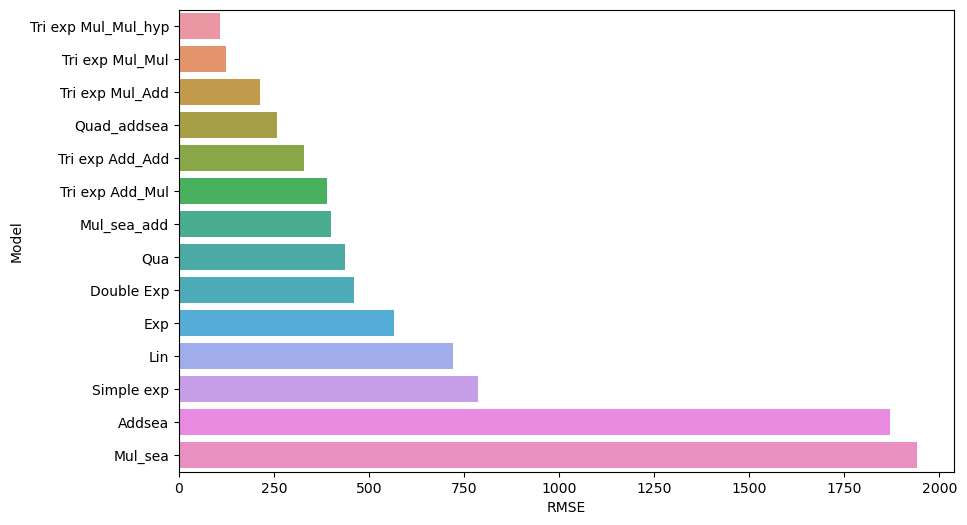

In [579]:
sns.barplot(data = rmse_models,x = 'RMSE',y = 'Model');

# From the above models, The Holt Winters model(Exponential smoothig model) with multiplicative seasonality and trend is performing well.As we know , if there is trend and seasonality in the data, Exponential smoothing models perform better.

# Now we will fit the model on the entire data set

In [580]:
model_final = ExponentialSmoothing(df['Sales'],seasonal='mul',trend = 'mul',
                                seasonal_periods=12).fit(smoothing_level = 0.2,smoothing_trend = 0.2,smoothing_seasonal = 0.2)

In [581]:
hw_forecast =model_final.forecast(12)

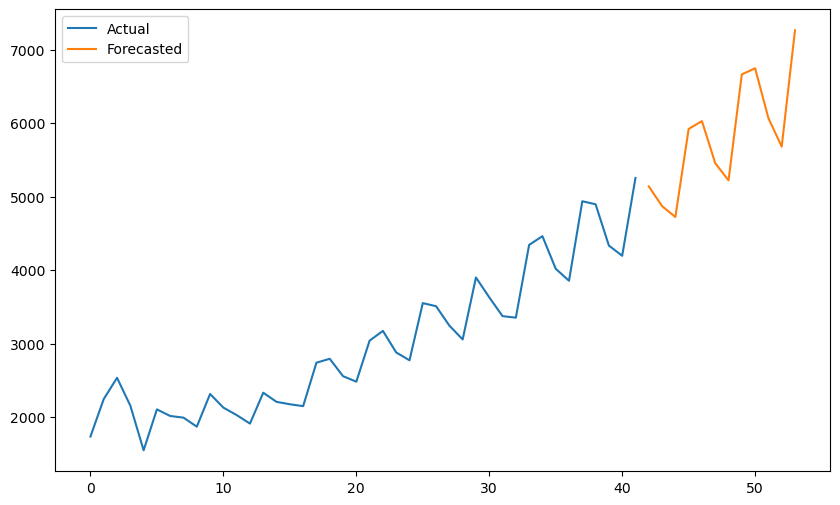

In [582]:
df['Sales'].plot(legend = True,label = 'Actual')
hw_forecast.plot(legend = True,label = 'Forecasted');

# From the above line plot we can say that the model performance is in line with the actual data and we can use this model for final predictions